In [ ]:
import pandas as pd
import numpy as np
import os
import glob
!pip install PyMuPDF # Install PyMuPDF to get fitz
import fitz
from google.colab import files

print("Setup selesai. Library sudah siap.")

Setup selesai. Library sudah siap.


In [ ]:
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

bnpb_drive_csv_path = '/content/drive/MyDrive/analisa big data/dibi.csv'
drive_base_path = '/content/drive/MyDrive/analisa big data/'

bnpb_csv_filename = bnpb_drive_csv_path

print(f"File DIBI BNPB akan diambil dari: {bnpb_csv_filename}")
print(f"Folder BMKG dan PDF akan diambil dari: {drive_base_path}")
print("Setup jalur Drive selesai. Silakan periksa dan sesuaikan jalur jika perlu.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File DIBI BNPB akan diambil dari: /content/drive/MyDrive/analisa big data/dibi.csv
Folder BMKG dan PDF akan diambil dari: /content/drive/MyDrive/analisa big data/
Setup jalur Drive selesai. Silakan periksa dan sesuaikan jalur jika perlu.


##ETL BMKG


In [ ]:
bmkg_path = os.path.join(drive_base_path, 'bmkg+pdf/bmkg/')
station_folders = [
    'Stasiun Geofisika Bandung',
    'Stasiun Geofisika Sukabumi',
    'Stasiun Klimatologi Dramaga (Bogor)'
]

all_weather_data = []

print(f"Memulai proses ETL data BMKG dari {len(station_folders)} stasiun...")

for station_name in station_folders:
    station_dir = os.path.join(bmkg_path, station_name)
    if not os.path.isdir(station_dir):
        print(f"Peringatan: Folder {station_dir} tidak ditemukan. Dilewati.")
        continue

    file_pattern = os.path.join(station_dir, '*.xlsx')
    file_list = glob.glob(file_pattern)

    for file_path in file_list:
        try:
            df_monthly = pd.read_excel(file_path, skiprows=7)

            df_monthly['Nama_Stasiun'] = station_name
            all_weather_data.append(df_monthly)
        except Exception as e:
            print(f"Gagal membaca {file_path}: {e}")

if all_weather_data:
    tabel_cuaca = pd.concat(all_weather_data, ignore_index=True)
    print(f"\nBerhasil menggabungkan {len(tabel_cuaca)} baris dari {len(all_weather_data)} file BMKG.")

    if 'Unnamed: 2' in tabel_cuaca.columns:
        tabel_cuaca = tabel_cuaca.drop(columns=['Unnamed: 2'])
        print("Kolom 'Unnamed: 2' telah dihapus.")
    else:
        print("Kolom 'Unnamed: 2' tidak ditemukan dalam DataFrame.")

    display(tabel_cuaca.head())
else:
    print("\nTidak ada data cuaca yang berhasil dimuat.")

Memulai proses ETL data BMKG dari 3 stasiun...

Berhasil menggabungkan 9574 baris dari 207 file BMKG.
Kolom 'Unnamed: 2' telah dihapus.


,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR,Nama_Stasiun
0,01-02-2020,21.2,29.4,23.4,84.0,8888.0,2.6,5.0,240.0,2.0,W,Stasiun Geofisika Bandung
1,02-02-2020,21.3,28.4,23.6,84.0,5.0,3.1,5.0,290.0,2.0,W,Stasiun Geofisika Bandung
2,03-02-2020,21.2,29.9,24.5,78.0,0.0,3.9,5.0,280.0,2.0,W,Stasiun Geofisika Bandung
3,04-02-2020,21.4,29.4,23.7,86.0,26.4,6.2,7.0,240.0,2.0,C,Stasiun Geofisika Bandung
4,05-02-2020,20.6,29.0,23.2,86.0,32.3,3.6,3.0,210.0,1.0,C,Stasiun Geofisika Bandung


DATA PREAPARATION BMKG

In [ ]:
NAMA_KOLOM_TANGGAL = 'TANGGAL'
NAMA_KOLOM_HUJAN = 'RR'

tabel_cuaca['tanggal'] = pd.to_datetime(tabel_cuaca[NAMA_KOLOM_TANGGAL], dayfirst=True, errors='coerce')

tabel_cuaca[NAMA_KOLOM_HUJAN] = pd.to_numeric(tabel_cuaca[NAMA_KOLOM_HUJAN], errors='coerce')
tabel_cuaca[NAMA_KOLOM_HUJAN] = tabel_cuaca[NAMA_KOLOM_HUJAN].replace([8888, 9999], np.nan)

tabel_cuaca.sort_values(by=['Nama_Stasiun', 'tanggal'], inplace=True)

tabel_cuaca[NAMA_KOLOM_HUJAN] = tabel_cuaca.groupby('Nama_Stasiun')[NAMA_KOLOM_HUJAN].transform(
    lambda x: x.interpolate(method='linear')
)
tabel_cuaca[NAMA_KOLOM_HUJAN] = tabel_cuaca[NAMA_KOLOM_HUJAN].fillna(0)


print("Membuat fitur lag dan rolling...")
grouped_weather_series = tabel_cuaca.groupby('Nama_Stasiun')[NAMA_KOLOM_HUJAN]

tabel_cuaca['CurahHujan_H-1'] = grouped_weather_series.shift(1)
tabel_cuaca['CurahHujan_H-2'] = grouped_weather_series.shift(2)

tabel_cuaca['TotalHujan_3Hari'] = grouped_weather_series.transform(lambda x: x.rolling(window=3, min_periods=1).sum())
tabel_cuaca['TotalHujan_7Hari'] = grouped_weather_series.transform(lambda x: x.rolling(window=7, min_periods=1).sum())

tabel_cuaca['Tanggal_Kejadian_Key'] = tabel_cuaca['tanggal'].dt.strftime('%Y-%m-%d')

print("Data BMKG selesai di-engineer.")
display(tabel_cuaca[['Nama_Stasiun', 'tanggal', NAMA_KOLOM_HUJAN, 'CurahHujan_H-1', 'TotalHujan_3Hari', 'Tanggal_Kejadian_Key']].head())

Membuat fitur lag dan rolling...
Data BMKG selesai di-engineer.


,Nama_Stasiun,tanggal,RR,CurahHujan_H-1,TotalHujan_3Hari,Tanggal_Kejadian_Key
2364,Stasiun Geofisika Bandung,2019-06-01,0.0,NaN,0.0,2019-06-01
2365,Stasiun Geofisika Bandung,2019-06-02,0.0,0.0,0.0,2019-06-02
2366,Stasiun Geofisika Bandung,2019-06-03,0.0,0.0,0.0,2019-06-03
2367,Stasiun Geofisika Bandung,2019-06-04,0.0,0.0,0.0,2019-06-04
2368,Stasiun Geofisika Bandung,2019-06-05,0.0,0.0,0.0,2019-06-05


##PEMETAAN DIBI DAN BMKG

In [ ]:
bnpb_csv_filename = bnpb_drive_csv_path

try:
    try:
        tabel_bencana = pd.read_csv(bnpb_csv_filename)
    except UnicodeDecodeError:
        tabel_bencana = pd.read_csv(bnpb_csv_filename, encoding='latin1')

    print(f"Data BNPB dimuat. Jumlah baris: {len(tabel_bencana)}")

except NameError:
    print("Peringatan: 'bnpb_csv_filename' tidak ditemukan. Pastikan file 'dibi.csv' ada di Drive Anda.")
    tabel_bencana = None
except Exception as e:
    print(f"Gagal memuat file BNPB: {e}")
    tabel_bencana = None

if tabel_bencana is not None:
    tabel_bencana['Tanggal_Kejadian_Key'] = pd.to_datetime(
        tabel_bencana['Tanggal / Waktu Kejadian'], errors='coerce'
    ).dt.strftime('%Y-%m-%d')

    mapping_stasiun = {
        'Bandung': 'Stasiun Geofisika Bandung',
        'Bogor': 'Stasiun Klimatologi Dramaga (Bogor)',
        'Cianjur': 'Stasiun Geofisika Sukabumi',
        'Garut': 'Stasiun Geofisika Bandung',
        'Karawang': 'Stasiun Geofisika Bandung',
        'Sukabumi': 'Stasiun Geofisika Sukabumi',

        'Bandung Barat': 'Stasiun Geofisika Bandung',
        'Bekasi': 'Stasiun Geofisika Bandung',
        'Indramayu': 'Stasiun Geofisika Bandung',
        'Kota Bandung': 'Stasiun Geofisika Bandung',
        'Kota Cimahi': 'Stasiun Geofisika Bandung',
        'Kota Tasikmalaya': 'Stasiun Geofisika Bandung',
        'Kuningan': 'Stasiun Geofisika Bandung',
        'Pangandaran': 'Stasiun Geofisika Bandung',
        'Purwakarta': 'Stasiun Geofisika Bandung',
        'Subang': 'Stasiun Geofisika Bandung',
        'Sumedang': 'Stasiun Geofisika Bandung',
        'Tasikmalaya': 'Stasiun Geofisika Bandung'
    }

    kabupaten_belum_terpetakan = []
    for kabupaten, stasiun in mapping_stasiun.items():
        if stasiun is None:
            kabupaten_belum_terpetakan.append(kabupaten)

    if len(kabupaten_belum_terpetakan) > 0:
        print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("PERINGATAN: Masih ada kabupaten yang di-set ke 'None'.")
        print("Anda wajib mengganti 'None' dengan nama stasiun yang benar:")
        for kab in sorted(kabupaten_belum_terpetakan):
            print(f"-> {kab}")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
    else:
        print("\nValidasi Sukses: Semua kabupaten di 'mapping_stasiun' telah memiliki nilai stasiun.")

    tabel_bencana['Stasiun_Key'] = tabel_bencana['Kabupaten'].map(mapping_stasiun)

    print("Data BNPB siap untuk digabungkan.")
    display(tabel_bencana[['id', 'Tanggal / Waktu Kejadian', 'Kabupaten', 'Tanggal_Kejadian_Key', 'Stasiun_Key']].head())

Data BNPB dimuat. Jumlah baris: 2507

Validasi Sukses: Semua kabupaten di 'mapping_stasiun' telah memiliki nilai stasiun.
Data BNPB siap untuk digabungkan.


,id,Tanggal / Waktu Kejadian,Kabupaten,Tanggal_Kejadian_Key,Stasiun_Key
0,fa5b474a-2804-45bd-b267-88e05cc3b663,2025-10-13 15:00:00.177,Pangandaran,2025-10-13,Stasiun Geofisika Bandung
1,5286a193-f56a-4efb-91d3-d5664ac0a351,2025-10-13 00:30:00.967,Tasikmalaya,2025-10-13,Stasiun Geofisika Bandung
2,4ea374b8-6e31-4898-9b61-6b72d714e0d5,2025-09-30 15:30:00.667,Bogor,2025-09-30,Stasiun Klimatologi Dramaga (Bogor)
3,20563f27-09f7-4403-bc59-0084ed9f0241,2025-09-26 19:30:00.167,Bogor,2025-09-26,Stasiun Klimatologi Dramaga (Bogor)
4,e4f66518-3149-4ae8-b4f9-23ff30525e26,2025-09-18 09:45:00.714,Karawang,2025-09-18,Stasiun Geofisika Bandung


## GABUNG DIBI + BMKG

In [ ]:
if 'tabel_bencana' in locals() and 'tabel_cuaca' in locals() and tabel_bencana is not None:
    if 'tanggal' not in tabel_cuaca.columns and 'TANGGAL' in tabel_cuaca.columns:
        tabel_cuaca['tanggal'] = pd.to_datetime(tabel_cuaca['TANGGAL'], dayfirst=True, errors='coerce')

    if 'Tanggal_Kejadian_Key' not in tabel_cuaca.columns and 'tanggal' in tabel_cuaca.columns:
        tabel_cuaca['Tanggal_Kejadian_Key'] = tabel_cuaca['tanggal'].dt.strftime('%Y-%m-%d')

    tabel_bencana_cuaca = pd.merge(
        tabel_bencana,
        tabel_cuaca,
        left_on=['Tanggal_Kejadian_Key', 'Stasiun_Key'],
        right_on=['Tanggal_Kejadian_Key', 'Nama_Stasiun'],
        how='left'
    )

    print(f"Berhasil menggabungkan data bencana dan cuaca.")
    print(f"Total baris di tabel gabungan: {len(tabel_bencana_cuaca)}")

    gagal_join = tabel_bencana_cuaca['Nama_Stasiun'].isna().sum()
    if gagal_join > 0:
        print(f"PERINGATAN: {gagal_join} baris bencana tidak berhasil digabung dengan data cuaca.")
        print("Ini mungkin karena kabupatennya tidak ada di 'mapping_stasiun' atau data cuaca di tanggal itu hilang.")

    columns_to_display = ['id', 'Kabupaten', 'Tanggal_Kejadian_Key', 'Nama_Stasiun', NAMA_KOLOM_HUJAN]
    if 'CurahHujan_H-1' in tabel_bencana_cuaca.columns:
        columns_to_display.append('CurahHujan_H-1')
    if 'TotalHujan_3Hari' in tabel_bencana_cuaca.columns:
        columns_to_display.append('TotalHujan_3Hari')

    display(tabel_bencana_cuaca[columns_to_display].head())
else:
    print("Gagal melanjutkan: 'tabel_bencana' atau 'tabel_cuaca' belum terdefinisi. Jalankan blok sebelumnya.")

Berhasil menggabungkan data bencana dan cuaca.
Total baris di tabel gabungan: 2510
PERINGATAN: 32 baris bencana tidak berhasil digabung dengan data cuaca.
Ini mungkin karena kabupatennya tidak ada di 'mapping_stasiun' atau data cuaca di tanggal itu hilang.


,id,Kabupaten,Tanggal_Kejadian_Key,Nama_Stasiun,RR,CurahHujan_H-1,TotalHujan_3Hari
0,fa5b474a-2804-45bd-b267-88e05cc3b663,Pangandaran,2025-10-13,NaN,NaN,NaN,NaN
1,5286a193-f56a-4efb-91d3-d5664ac0a351,Tasikmalaya,2025-10-13,NaN,NaN,NaN,NaN
2,4ea374b8-6e31-4898-9b61-6b72d714e0d5,Bogor,2025-09-30,Stasiun Klimatologi Dramaga (Bogor),35.6,0.0,35.6
3,20563f27-09f7-4403-bc59-0084ed9f0241,Bogor,2025-09-26,Stasiun Klimatologi Dramaga (Bogor),1.2,0.0,38.2
4,e4f66518-3149-4ae8-b4f9-23ff30525e26,Karawang,2025-09-18,Stasiun Geofisika Bandung,51.0,3.0,54.0


### Simpan Hasil Penggabungan Data Bencana dan Cuaca

Sel ini akan menyimpan `tabel_bencana_cuaca` ke dalam format CSV. Ini berguna untuk analisis lebih lanjut atau untuk dibagikan.

In [ ]:
if 'tabel_bencana_cuaca' in locals() and tabel_bencana_cuaca is not None:
    output_filename = 'data_bencana_cuaca_gabungan.csv'
    tabel_bencana_cuaca.to_csv(output_filename, index=False)
    print(f"Data gabungan berhasil disimpan ke '{output_filename}'")

    # files.download(output_filename)
else:
    print("Gagal menyimpan: 'tabel_bencana_cuaca' belum terdefinisi atau kosong.")

Data gabungan berhasil disimpan ke 'data_bencana_cuaca_gabungan.csv'


## ETL PDF

In [ ]:
pdf_mapping_path = os.path.join(drive_base_path, 'pdf_mapping.csv')
print(f"Path untuk mapping PDF diatur ke: {pdf_mapping_path}")

Path untuk mapping PDF diatur ke: /content/drive/MyDrive/analisa big data/pdf_mapping.csv


In [ ]:
print(f"Memuat ulang file mapping PDF dari: {pdf_mapping_path} dengan delimiter ';'")

try:
    mapping_df = pd.read_csv(pdf_mapping_path, delimiter=';')
    mapping_df['id'] = mapping_df['id'].astype(str)
    print(f"File '{os.path.basename(pdf_mapping_path)}' berhasil dimuat dan diparsing.")
    print("Lima baris pertama dari mapping_df setelah diperbaiki:")
    display(mapping_df.head())

except FileNotFoundError:
    print(f"Gagal memuat '{os.path.basename(pdf_mapping_path)}': File tidak ditemukan di {pdf_mapping_path}")
    mapping_df = pd.DataFrame(columns=['id', 'filename'])
except Exception as e:
    print(f"Gagal memuat atau memproses mapping PDF dengan delimiter ';': {e}")
    mapping_df = pd.DataFrame(columns=['id', 'filename'])

Memuat ulang file mapping PDF dari: /content/drive/MyDrive/analisa big data/pdf_mapping.csv dengan delimiter ';'
File 'pdf_mapping.csv' berhasil dimuat dan diparsing.
Lima baris pertama dari mapping_df setelah diperbaiki:


,id,filename
0,eee63243-5005-4ad4-9506-05d1771f737d,InfoBencana_indramayu_7feb2021.pdf
1,d9a79ec3-9dad-42e9-bbe7-a5866067a5c0,InfoBencana_bekasi_20feb2021.pdf
2,764cd4a6-c47f-4eb2-9a3c-1c520992808b,InfoBencana_bandung_15feb2020.pdf
3,0ea7a9d9-74f4-4ef4-b96d-d1b85bc6abb4,info_bencana_bandung_maret2020.pdf
4,165587a2-130e-4da3-b7db-0bac4804a63a,info_bencana_karawang_februari2020.pdf


### Ekstraksi Teks dari PDF

In [ ]:
pdf_dir = os.path.join(drive_base_path, 'bmkg+pdf/pdf/') # Corrected path to 'pdf/'

all_pdf_texts = []

if not os.path.exists(pdf_dir):
    print(f"Peringatan: Direktori PDF tidak ditemukan di {pdf_dir}. Pastikan jalur sudah benar.")
else:
    pdf_files = glob.glob(os.path.join(pdf_dir, '*.pdf'))
    print(f"Memulai ekstraksi teks dari {len(pdf_files)} file PDF di {pdf_dir}...")

    for pdf_path in pdf_files:
        try:
            doc = fitz.open(pdf_path)
            text = ""
            for page in doc:
                text += page.get_text()
            all_pdf_texts.append({'filename': os.path.basename(pdf_path), 'Teks_Naratif': text})
            doc.close()
        except Exception as e:
            print(f"Gagal memproses {os.path.basename(pdf_path)}: {e}")

    tabel_teks_pdf = pd.DataFrame(all_pdf_texts)

    if not tabel_teks_pdf.empty:
        print(f"Berhasil mengekstrak teks dari {len(tabel_teks_pdf)} PDF.")
        print("Lima baris pertama dari tabel_teks_pdf:")
        display(tabel_teks_pdf.head())
    else:
        print("Tidak ada teks yang berhasil diekstrak dari PDF.")
        tabel_teks_pdf = pd.DataFrame(columns=['filename', 'Teks_Naratif'])

Memulai ekstraksi teks dari 50 file PDF di /content/drive/MyDrive/analisa big data/bmkg+pdf/pdf/...
Berhasil mengekstrak teks dari 50 PDF.
Lima baris pertama dari tabel_teks_pdf:


,filename,Teks_Naratif
0,InfoBencana_indramayu_7feb2021.pdf,Beranda / Empat Sungai Meluap Sebabkan Banjir ...
1,InfoBencana_bekasi_20feb2021.pdf,"Redaksi Kontak Kami\nRabu, 12 November 2025\..."
2,InfoBencana_bandung_15feb2020.pdf,B\nandung (ANTARA) - Banjir yang melanda sebag...
3,InfoBencana_cianjur_3des2024.pdf,Beranda / [UPDATE] Banjir dan Tanah Longsor di...
4,InfoBencana_indramayu_6des2020.pdf,\nAdvertisement\nCirebon\nPurwakarta\nKab. Ba...


In [ ]:
if 'mapping_df' in locals() and not mapping_df.empty and 'tabel_teks_pdf' in locals() and not tabel_teks_pdf.empty:
    tabel_teks_final = pd.merge(mapping_df[['id', 'filename']], tabel_teks_pdf, on='filename', how='inner')
    print(f"Berhasil menggabungkan mapping dengan teks PDF. Jumlah baris: {len(tabel_teks_final)}")

    tabel_bencana_cuaca['id'] = tabel_bencana_cuaca['id'].astype(str)

    ids_with_pdf_text = tabel_teks_final['id'].unique()

    tabel_bencana_cuaca_filtered = tabel_bencana_cuaca[tabel_bencana_cuaca['id'].isin(ids_with_pdf_text)].copy()

    tabel_analitik_master = pd.merge(
        tabel_bencana_cuaca_filtered,
        tabel_teks_final[['id', 'Teks_Naratif']],
        on='id',
        how='left'
    )

    print("\nBerhasil menggabungkan data PDF ke Tabel Analitik Master.")
    print(f"Total baris di Tabel Analitik Master: {len(tabel_analitik_master)}")
    print(f"Jumlah baris dengan teks PDF: {tabel_analitik_master['Teks_Naratif'].count()} / {len(ids_with_pdf_text)}")

    tabel_analitik_master['Tanggal / Waktu Kejadian'] = pd.to_datetime(tabel_analitik_master['Tanggal / Waktu Kejadian'])
    tabel_analitik_master = tabel_analitik_master.sort_values(by='Tanggal / Waktu Kejadian', ascending=False)
    tabel_analitik_master_top50 = tabel_analitik_master.head(50)

    print("\nMenampilkan 50 entri bencana paling baru dengan data cuaca dan teks PDF:")
    display(tabel_analitik_master_top50[['id', 'Tanggal / Waktu Kejadian', 'Nama Kejadian', 'Teks_Naratif', 'RR', 'TotalHujan_3Hari']].head())
else:
    print("Gagal melanjutkan: 'mapping_df' atau 'tabel_teks_pdf' belum terdefinisi atau kosong. Pastikan langkah sebelumnya berjalan sukses.")
    tabel_analitik_master_top50 = pd.DataFrame()

Berhasil menggabungkan mapping dengan teks PDF. Jumlah baris: 48

Berhasil menggabungkan data PDF ke Tabel Analitik Master.
Total baris di Tabel Analitik Master: 48
Jumlah baris dengan teks PDF: 48 / 48

Menampilkan 50 entri bencana paling baru dengan data cuaca dan teks PDF:


,id,Tanggal / Waktu Kejadian,Nama Kejadian,Teks_Naratif,RR,TotalHujan_3Hari
0,1979ab73-cfa7-43b6-8991-d81ef3ca18c6,2025-07-07 22:00:00.279,Banjir,Scroll ke bawah untuk membaca berita\n Penyeba...,1.7,19.9
1,c337acfc-d62c-4e73-a7c2-1f947e0ccea1,2025-03-07 20:00:00.000,Banjir,INFOBENCANA \nData dan Informasi Kebencanaan B...,20.0,44.8
2,16e98620-e9f4-4472-9d6b-ed3d5b781e99,2025-03-04 16:00:00.000,Banjir,Advertisement\nAdvertisement\n \n \nTiga Kecam...,13.1,41.6
3,2102fd81-93c9-47ad-9cea-e09dd8c3fb50,2025-03-04 01:00:00.000,Banjir,Home\nNews\nPeristiwa\nAkibat Banjir Besar di ...,13.1,41.6
4,402f514a-4372-4134-943e-af52ff6d8f56,2025-03-02 20:30:00.000,Banjir,Baca berita tanpa iklan. Gabung Kompas.com+\nB...,0.0,60.6


# **DATA PREPARATION**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords


if 'tabel_bencana_cuaca' in locals():
    tabel_bencana_cuaca['id'] = tabel_bencana_cuaca['id'].astype(str)
else:
    print("Variabel 'tabel_bencana_cuaca' tidak ditemukan. Harap jalankan blok sebelumnya.")

if 'tabel_teks_final' in locals():
    tabel_teks_final['id'] = tabel_teks_final['id'].astype(str)
else:
    print("Variabel 'tabel_teks_final' tidak ditemukan. Harap jalankan blok sebelumnya.")

print("Membuat Tabel Analitik Master (1800+ baris)...")

tabel_analitik_master = pd.merge(
    tabel_bencana_cuaca,
    tabel_teks_final[['id', 'Teks_Naratif']],
    on='id',
    how='left'
)

print(f"Tabel Analitik Master berhasil dibuat. Total baris: {len(tabel_analitik_master)}")
print(f"Jumlah baris dengan teks PDF: {tabel_analitik_master['Teks_Naratif'].notnull().sum()}")

Membuat Tabel Analitik Master (1800+ baris)...
Tabel Analitik Master berhasil dibuat. Total baris: 2510
Jumlah baris dengan teks PDF: 48


In [ ]:
print("Memulai verifikasi dan koreksi kolom dampak...")

kolom_dampak = [
    'Meninggal', 'Hilang', 'Luka/sakit', 'Menderita', 'Mengungsi',
    'Rumah rusak berat', 'Rumah rusak sedang', 'Rumah rusak ringan', 'Rumah terendam',
    'Satuan pendidikan rusak', 'Rumah ibadat rusak', 'Fasilitas layanan kesehatan rusak',
    'Kantor rusak', 'Jembatan rusak'
]

kolom_dampak_valid = [col for col in kolom_dampak if col in tabel_analitik_master.columns]

print(f"\nKolom dampak yang akan diproses (valid): {kolom_dampak_valid}")

initial_na_counts = tabel_analitik_master[kolom_dampak_valid].isnull().sum()
tabel_analitik_master[kolom_dampak_valid] = tabel_analitik_master[kolom_dampak_valid].fillna(0)
print("Missing values pada kolom dampak yang valid telah diisi dengan 0.")

final_na_counts = tabel_analitik_master[kolom_dampak_valid].isnull().sum()

print("\nJumlah missing values per kolom dampak (setelah pengisian 0):")
print(final_na_counts[final_na_counts > 0] if final_na_counts.sum() > 0 else "Tidak ada missing values.")

print("Verifikasi dan koreksi kolom dampak selesai.")

Memulai verifikasi dan koreksi kolom dampak...

Kolom dampak yang akan diproses (valid): ['Meninggal', 'Hilang', 'Menderita', 'Mengungsi']
Missing values pada kolom dampak yang valid telah diisi dengan 0.

Jumlah missing values per kolom dampak (setelah pengisian 0):
Tidak ada missing values.
Verifikasi dan koreksi kolom dampak selesai.


In [ ]:
print("Inspecting columns of tabel_analitik_master to find correct impact column names...")
print(tabel_analitik_master.columns)


Inspecting columns of tabel_analitik_master to find correct impact column names...
Index(['id', 'Tanggal / Waktu Kejadian', 'Minggu', 'Bulan', 'Tahun',
       'Kode Provinsi', 'Provinsi', 'Kode Kabupaten', 'Kabupaten',
       'Kode Jenis Kejadian', 'Nama Kejadian', 'Jenis Bencana', 'is_bencana',
       'Jumlah Kejadian', 'Meninggal', 'Hilang', 'Luka / Sakit', 'Menderita',
       'Mengungsi', 'Rumah Rusak Berat', 'Rumah Rusak Sedang',
       'Rumah Rusak Ringan', 'Rumah Terendam', 'Satuan Pendidikan Rusak',
       'Rumah Ibadat Rusak', 'Fasilitas Pelayanan Kesehatan Rusak',
       'Kantor Rusak', 'Jembatan Rusak', 'Tanggal_Kejadian_Key', 'Stasiun_Key',
       'TANGGAL', 'TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS', 'FF_X', 'DDD_X',
       'FF_AVG', 'DDD_CAR', 'Nama_Stasiun', 'tanggal', 'CurahHujan_H-1',
       'CurahHujan_H-2', 'TotalHujan_3Hari', 'TotalHujan_7Hari',
       'Teks_Naratif'],
      dtype='object')


In [ ]:
print("Memulai re-evaluasi deteksi outlier...")

kolom_outlier_check_actual = [
    'Mengungsi',
    'Rumah Rusak Berat',
    'Meninggal',
    'Jembatan Rusak'
]

kolom_outlier_valid = [col for col in kolom_outlier_check_actual if col in tabel_analitik_master.columns]

if not kolom_outlier_valid:
    print("Peringatan: Tidak ada kolom valid untuk deteksi outlier dari daftar yang ditentukan.")
else:
    print(f"Kolom yang akan digunakan untuk deteksi outlier: {kolom_outlier_valid}")

    tabel_analitik_master['is_Outlier_Reevaluated'] = False

    print("Menerapkan metode IQR untuk mendeteksi outlier...")
    for col in kolom_outlier_valid:
        if pd.api.types.is_numeric_dtype(tabel_analitik_master[col]):
            Q1 = tabel_analitik_master[col].quantile(0.25)
            Q3 = tabel_analitik_master[col].quantile(0.75)
            IQR = Q3 - Q1
            Upper_Bound = Q3 + (1.5 * IQR)

            tabel_analitik_master.loc[tabel_analitik_master[col] > Upper_Bound, 'is_Outlier_Reevaluated'] = True
            print(f"  - Kolom '{col}': Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, Upper Bound={Upper_Bound:.2f}")
        else:
            print(f"  - Peringatan: Kolom '{col}' bukan tipe numerik, dilewati untuk deteksi outlier.")

    total_outliers = tabel_analitik_master['is_Outlier_Reevaluated'].sum()
    print(f"\nTotal baris ditandai sebagai outlier setelah re-evaluasi: {total_outliers}")

    print("\nStatistik Deskriptif untuk Kolom Outlier:")
    display(tabel_analitik_master[kolom_outlier_valid].describe())

    print("\nContoh baris yang terdeteksi sebagai outlier (Head):")
    display(tabel_analitik_master[tabel_analitik_master['is_Outlier_Reevaluated'] == True].head())

    print("\nContoh baris yang terdeteksi sebagai outlier (Tail):")
    display(tabel_analitik_master[tabel_analitik_master['is_Outlier_Reevaluated'] == True].tail())

    print("\nImplikasi Outlier:")
    print("Outlier adalah nilai data yang secara signifikan berbeda dari sebagian besar data lainnya. Dalam konteks data bencana, outlier ini seringkali merepresentasikan kejadian bencana yang luar biasa parah atau memiliki dampak yang sangat besar dibandingkan kejadian rata-rata.")
    print("Implikasinya adalah:")
    print("  - **Analisis Statistik**: Outlier dapat secara signifikan memengaruhi rata-rata dan standar deviasi, sehingga statistik deskriptif mungkin tidak mewakili kondisi 'normal' dengan baik. Model yang sensitif terhadap distribusi data (misalnya regresi linier) juga bisa terpengaruh.")
    print("  - **Identifikasi Kasus Kritis**: Outlier bisa menjadi target utama untuk analisis lebih mendalam karena mereka menyoroti kejadian yang membutuhkan perhatian khusus atau penanganan darurat yang berbeda.")
    print("  - **Pemodelan Prediktif**: Tergantung pada tujuan model, outlier dapat dipertahankan (jika mewakili kejadian penting yang ingin diprediksi), di-transformasi, atau dihapus (jika dianggap sebagai noise atau anomali yang tidak relevan dengan pola umum).)")
    print("  - **Alokasi Sumber Daya**: Mengidentifikasi outlier dalam dampak bencana dapat membantu dalam perencanaan alokasi sumber daya yang lebih efektif untuk penanggulangan bencana berskala besar.")

    print("Deteksi outlier selesai.")

Memulai re-evaluasi deteksi outlier...
Kolom yang akan digunakan untuk deteksi outlier: ['Mengungsi', 'Rumah Rusak Berat', 'Meninggal', 'Jembatan Rusak']
Menerapkan metode IQR untuk mendeteksi outlier...
  - Kolom 'Mengungsi': Q1=0.00, Q3=0.00, IQR=0.00, Upper Bound=0.00
  - Kolom 'Rumah Rusak Berat': Q1=0.00, Q3=0.00, IQR=0.00, Upper Bound=0.00
  - Kolom 'Meninggal': Q1=0.00, Q3=0.00, IQR=0.00, Upper Bound=0.00
  - Kolom 'Jembatan Rusak': Q1=0.00, Q3=0.00, IQR=0.00, Upper Bound=0.00

Total baris ditandai sebagai outlier setelah re-evaluasi: 811

Statistik Deskriptif untuk Kolom Outlier:


,Mengungsi,Rumah Rusak Berat,Meninggal,Jembatan Rusak
count,2510.000000,2510.000000,2510.000000,2510.000000
mean,82.999602,1.782470,0.085259,0.071713
std,1144.070508,22.661785,0.931653,0.934501
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,37281.000000,755.000000,40.000000,33.000000



Contoh baris yang terdeteksi sebagai outlier (Head):


,id,Tanggal / Waktu Kejadian,Minggu,Bulan,Tahun,Kode Provinsi,Provinsi,Kode Kabupaten,Kabupaten,Kode Jenis Kejadian,...,FF_AVG,DDD_CAR,Nama_Stasiun,tanggal,CurahHujan_H-1,CurahHujan_H-2,TotalHujan_3Hari,TotalHujan_7Hari,Teks_Naratif,is_Outlier_Reevaluated
3,20563f27-09f7-4403-bc59-0084ed9f0241,2025-09-26 19:30:00.167,39,9,2025,32,Jawa Barat,32.01,Bogor,1020,...,3.0,C,Stasiun Klimatologi Dramaga (Bogor),2025-09-26,0.0,37.0,38.2,46.4,NaN,True
8,5fb8bb33-aed1-433c-9cf0-5665c88b3fe1,2025-08-12 04:00:00.871,33,8,2025,32,Jawa Barat,32.01,Bogor,1020,...,1.0,C,Stasiun Klimatologi Dramaga (Bogor),2025-08-12,43.0,115.2,169.3,267.3,NaN,True
9,2e9666a4-4d4f-49f8-a79e-7cb1ec3b051f,2025-08-12 04:00:00.871,33,8,2025,32,Jawa Barat,32.01,Bogor,1022,...,1.0,C,Stasiun Klimatologi Dramaga (Bogor),2025-08-12,43.0,115.2,169.3,267.3,NaN,True
11,3f02bcdd-25d7-4b2c-844c-9d79817d3438,2025-08-11 08:30:00.920,33,8,2025,32,Jawa Barat,32.01,Bogor,1020,...,2.0,C,Stasiun Klimatologi Dramaga (Bogor),2025-08-11,115.2,1.8,160.0,322.7,NaN,True
13,b1fdf5ce-e0df-41f9-a262-069cbd1db8cc,2025-08-09 18:00:00.557,32,8,2025,32,Jawa Barat,32.01,Bogor,1020,...,3.0,C,Stasiun Klimatologi Dramaga (Bogor),2025-08-09,55.2,0.0,57.0,189.1,NaN,True



Contoh baris yang terdeteksi sebagai outlier (Tail):


,id,Tanggal / Waktu Kejadian,Minggu,Bulan,Tahun,Kode Provinsi,Provinsi,Kode Kabupaten,Kabupaten,Kode Jenis Kejadian,...,FF_AVG,DDD_CAR,Nama_Stasiun,tanggal,CurahHujan_H-1,CurahHujan_H-2,TotalHujan_3Hari,TotalHujan_7Hari,Teks_Naratif,is_Outlier_Reevaluated
2499,28313afd-1455-45d7-85f1-d95668c29349,2020-01-09 00:01:00.000,2,1,2020,32,Jawa Barat,32.05,Garut,1020,...,2.0,W,Stasiun Geofisika Bandung,2020-01-09,0.30,3.00,9.30,10.400000,NaN,True
2500,c8cdb150-01b5-4784-9183-9d54ad51b287,2020-01-09 00:01:00.000,2,1,2020,32,Jawa Barat,32.13,Subang,1010,...,2.0,W,Stasiun Geofisika Bandung,2020-01-09,0.30,3.00,9.30,10.400000,NaN,True
2506,be731dfb-7d2d-4d50-a429-f64a9c425f94,2020-01-01 05:00:00.000,1,1,2020,32,Jawa Barat,32.01,Bogor,1013,...,1.0,C,Stasiun Klimatologi Dramaga (Bogor),2020-01-01,35.56,26.72,106.68,133.933333,Baca berita tanpa iklan. Gabung Kompas.com+\nB...,True
2507,88990e59-2978-47a3-b273-953d1dbe7223,2020-01-01 05:00:00.000,1,1,2020,32,Jawa Barat,32.15,Karawang,1010,...,2.0,W,Stasiun Geofisika Bandung,2020-01-01,0.00,0.00,13.40,13.400000,Baca berita tanpa iklan. Gabung Kompas.com+\n4...,True
2508,1e8f6adf-3313-4961-82fc-ec6c5f70bc3b,2020-01-01 05:00:00.000,1,1,2020,32,Jawa Barat,32.16,Bekasi,1010,...,2.0,W,Stasiun Geofisika Bandung,2020-01-01,0.00,0.00,13.40,13.400000,NaN,True



Implikasi Outlier:
Outlier adalah nilai data yang secara signifikan berbeda dari sebagian besar data lainnya. Dalam konteks data bencana, outlier ini seringkali merepresentasikan kejadian bencana yang luar biasa parah atau memiliki dampak yang sangat besar dibandingkan kejadian rata-rata.
Implikasinya adalah:
  - **Analisis Statistik**: Outlier dapat secara signifikan memengaruhi rata-rata dan standar deviasi, sehingga statistik deskriptif mungkin tidak mewakili kondisi 'normal' dengan baik. Model yang sensitif terhadap distribusi data (misalnya regresi linier) juga bisa terpengaruh.
  - **Identifikasi Kasus Kritis**: Outlier bisa menjadi target utama untuk analisis lebih mendalam karena mereka menyoroti kejadian yang membutuhkan perhatian khusus atau penanganan darurat yang berbeda.
  - **Pemodelan Prediktif**: Tergantung pada tujuan model, outlier dapat dipertahankan (jika mewakili kejadian penting yang ingin diprediksi), di-transformasi, atau dihapus (jika dianggap sebagai noise at

## Klarifikasi Persiapan Data Teks

### Subtask:
Review dan klarifikasi persiapan data teks, termasuk pembersihan teks dan pembuatan fitur berbasis kamus, dengan mengonfirmasi relevansi kata kunci seperti `Kunci_Kebutuhan` dan `Kunci_Infrastruktur`, menjelaskan bagaimana fitur-fitur ini dapat digunakan dalam analisis, dan menunjukkan contoh teks yang telah dibersihkan dan fitur yang diekstraksi. Terakhir, konfirmasi bahwa semua langkah persiapan data selesai dan siap untuk analisis lebih lanjut.

#### Instructions:
1.  **Konfirmasi Relevansi Kata Kunci**: Jelaskan relevansi dan asal usul kata kunci dalam `Kunci_Kebutuhan` dan `Kunci_Infrastruktur` berdasarkan konteks data bencana.
2.  **Jelaskan Penggunaan Fitur**: Jelaskan bagaimana fitur biner `Fitur_Butuh_Logistik` dan `Fitur_Infrastruktur_Rusak` dapat digunakan dalam analisis data lebih lanjut, misalnya untuk identifikasi kebutuhan cepat atau prioritas penanganan.
3.  **Tampilkan Contoh**: Tampilkan beberapa contoh baris dari `tabel_analitik_master` yang menunjukkan:
    *   `Teks_Naratif` (asli)
    *   `Teks_Bersih` (setelah pembersihan)
    *   Nilai `Fitur_Butuh_Logistik` dan `Fitur_Infrastruktur_Rusak`
    *   Kolom `is_Outlier_Reevaluated` untuk konteks
4.  **Konfirmasi Penyelesaian**: Konfirmasi bahwa semua langkah persiapan data telah selesai dan data siap untuk tahap analisis berikutnya.

### 1. Konfirmasi Relevansi Kata Kunci dan 2. Jelaskan Penggunaan Fitur

**Relevansi Kata Kunci:**
Kata kunci yang digunakan dalam `Kunci_Kebutuhan` dan `Kunci_Infrastruktur` berasal dari pemahaman umum mengenai dampak dan kebutuhan pasca-bencana di Indonesia, serta observasi awal terhadap teks naratif PDF yang tersedia. Mereka dipilih untuk mencerminkan dua kategori utama informasi yang seringkali krusial dalam respons bencana:

*   `Kunci_Kebutuhan`: Berfokus pada item-item logistik dan bantuan dasar yang seringkali dibutuhkan oleh korban bencana. Contohnya, "logistik", "selimut", "air bersih", "makanan", "alat kebersihan". Kehadiran kata-kata ini dalam teks naratif dapat secara langsung mengindikasikan adanya kebutuhan mendesak bagi para korban.
*   `Kunci_Infrastruktur`: Berfokus pada kerusakan atau gangguan pada fasilitas umum dan prasarana. Contohnya, "jembatan", "jalan terputus/terisolir", "fasilitas ibadah/mushola". Kata-kata ini menandakan adanya kerusakan infrastruktur yang mungkin memerlukan perbaikan segera atau mempengaruhi akses bantuan.

**Penggunaan Fitur dalam Analisis:**
Fitur biner `Fitur_Butuh_Logistik` dan `Fitur_Infrastruktur_Rusak` yang diekstraksi dari teks naratif sangat berguna untuk analisis lebih lanjut:

*   **Identifikasi Kebutuhan Cepat**: `Fitur_Butuh_Logistik` dapat digunakan untuk dengan cepat mengidentifikasi kejadian bencana di mana kebutuhan logistik sangat menonjol. Ini membantu dalam alokasi sumber daya yang efisien dan pengiriman bantuan yang tepat sasaran.
*   **Prioritas Penanganan Infrastruktur**: `Fitur_Infrastruktur_Rusak` memungkinkan identifikasi kejadian di mana infrastruktur kritis mengalami kerusakan. Informasi ini penting untuk perencanaan perbaikan, pembukaan jalur evakuasi/distribusi, dan estimasi biaya pemulihan.
*   **Korelasi dengan Data Numerik**: Kedua fitur ini dapat dikorelasikan dengan data dampak numerik (misalnya, jumlah pengungsi, rumah rusak) dan data cuaca (`RR`, `TotalHujan_3Hari`) untuk menemukan pola. Misalnya, apakah bencana dengan curah hujan tinggi lebih sering menyebabkan kerusakan infrastruktur tertentu?
*   **Segmentasi dan Pemodelan**: Fitur-fitur ini dapat menjadi variabel prediktor atau target dalam model machine learning untuk memprediksi jenis kebutuhan atau dampak tertentu berdasarkan narasi bencana, atau untuk mengelompokkan (clustering) kejadian bencana berdasarkan karakteristik teksualnya.

In [ ]:
print("Memulai persiapan data teks: pembersihan dan ekstraksi fitur...")

# Download NLTK stopwords jika belum ada
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words_id = set(stopwords.words('indonesian'))

# Tambahkan kata-kata penghenti tambahan yang mungkin muncul dalam laporan/berita namun tidak relevan untuk topik bencana
additional_stop_words = [
    'advertisement', 'kompascom', 'news', 'bola', 'wib', 'am', 'baca', 'beranda', 'ang', 'karaw',
    'gambar', 'selengkapnya', 'foto', 'video', 'lihat', 'klik', 'link', 'tanggal', 'tahun',
    'minggu', 'hari', 'bulan', 'ke', 'ini', 'itu', 'terjadi', 'berita', 'data', 'dampak',
    'pasca', 'sejak', 'detikjabar', 'detikcom', 'jakarta', 'rabu', 'kamis', 'jumat', 'sabtu', 'minggu', 'senin', 'selasa',
    'mei', 'juni', 'juli', 'agustus', 'september', 'oktober', 'november', 'desember', 'januari', 'februari', 'maret', 'april',
    'komentar', 'indonesia', 'regional'
]
stop_words_id.update(additional_stop_words)

def clean_text_and_tokenize(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # Hapus karakter non-alphanumeric (kecuali spasi)
    text = re.sub(r'\b\d+\b', '', text) # Hapus angka tunggal (bukan bagian dari kata)
    words = text.split()
    words = [word for word in words if word not in stop_words_id and len(word) > 2] # Hapus stop words & kata pendek
    return words

# Ganti 'Teks_Bersih' dengan 'Teks_Tokenized' yang langsung berupa list token untuk LDA
tabel_analitik_master['Teks_Tokenized'] = tabel_analitik_master['Teks_Naratif'].apply(clean_text_and_tokenize)
print("Kolom 'Teks_Tokenized' telah dibuat.")

# Definisi kata kunci (sesuai klarifikasi)
Kunci_Kebutuhan = [
    'logistik', 'selimut', 'air bersih', 'makanan', 'alat kebersihan',
    'kesehatan', 'obat', 'pangan', 'sandang', 'shelter', 'posko pengungsian'
]
Kunci_Infrastruktur = [
    'jembatan', 'jalan terputus', 'terisolir', 'fasilitas ibadah', 'mushola',
    'sekolah', 'rumah sakit', 'puskemas', 'kantor', 'bangunan rusak', 'listrik padam', 'telekomunikasi terganggu'
]

def check_keywords_from_tokens(tokens, keywords):
    if not tokens:
        return 0
    text_clean = ' '.join(tokens)
    for keyword in keywords:
        if keyword in text_clean:
            return 1
    return 0

tabel_analitik_master['Fitur_Butuh_Logistik'] = tabel_analitik_master['Teks_Tokenized'].apply(lambda x: check_keywords_from_tokens(x, Kunci_Kebutuhan))
tabel_analitik_master['Fitur_Infrastruktur_Rusak'] = tabel_analitik_master['Teks_Tokenized'].apply(lambda x: check_keywords_from_tokens(x, Kunci_Infrastruktur))
print("Fitur 'Fitur_Butuh_Logistik' dan 'Fitur_Infrastruktur_Rusak' telah dibuat.")

print("Persiapan data teks selesai.")

Memulai persiapan data teks: pembersihan dan ekstraksi fitur...
Kolom 'Teks_Tokenized' telah dibuat.
Fitur 'Fitur_Butuh_Logistik' dan 'Fitur_Infrastruktur_Rusak' telah dibuat.
Persiapan data teks selesai.


In [ ]:
print("\nMenampilkan contoh teks asli, teks bersih, dan fitur yang diekstraksi (Instruction 3):\n")

kolom_tampil = [
    'id', 'Nama Kejadian', 'Teks_Naratif', 'Teks_Bersih',
    'Fitur_Butuh_Logistik', 'Fitur_Infrastruktur_Rusak', 'is_Outlier_Reevaluated'
]

contoh_teks_ada = tabel_analitik_master[tabel_analitik_master['Teks_Naratif'].notnull()].head(5)
contoh_teks_tidak_ada = tabel_analitik_master[tabel_analitik_master['Teks_Naratif'].isnull()].head(5)

contoh_display = pd.concat([contoh_teks_ada, contoh_teks_tidak_ada])

display(contoh_display[kolom_tampil])


Menampilkan contoh teks asli, teks bersih, dan fitur yang diekstraksi (Instruction 3):



,id,Nama Kejadian,Teks_Naratif,Teks_Bersih,Fitur_Butuh_Logistik,Fitur_Infrastruktur_Rusak,is_Outlier_Reevaluated
29,1979ab73-cfa7-43b6-8991-d81ef3ca18c6,Banjir,Scroll ke bawah untuk membaca berita\n Penyeba...,scroll membaca berita penyebab tambang ilegal ...,0,0,True
110,c337acfc-d62c-4e73-a7c2-1f947e0ccea1,Banjir,INFOBENCANA \nData dan Informasi Kebencanaan B...,infobencana data informasi kebencanaan bulanan...,1,1,True
114,16e98620-e9f4-4472-9d6b-ed3d5b781e99,Banjir,Advertisement\nAdvertisement\n \n \nTiga Kecam...,advertisement advertisement kecamatan karawang...,1,1,True
116,2102fd81-93c9-47ad-9cea-e09dd8c3fb50,Banjir,Home\nNews\nPeristiwa\nAkibat Banjir Besar di ...,home news peristiwa akibat banjir bekasi ribua...,1,1,True
126,402f514a-4372-4134-943e-af52ff6d8f56,Banjir,Baca berita tanpa iklan. Gabung Kompas.com+\nB...,baca berita iklan gabung kompascom banjir long...,1,1,True
0,fa5b474a-2804-45bd-b267-88e05cc3b663,Banjir,NaN,,0,0,False
1,5286a193-f56a-4efb-91d3-d5664ac0a351,Banjir,NaN,,0,0,False
2,4ea374b8-6e31-4898-9b61-6b72d714e0d5,Banjir,NaN,,0,0,False
3,20563f27-09f7-4403-bc59-0084ed9f0241,Tanah Longsor,NaN,,0,0,True
4,e4f66518-3149-4ae8-b4f9-23ff30525e26,Banjir,NaN,,0,0,False


#**CLUSTERING DENGAN K-MEANS**

Memulai Analisis Clustering dan Deteksi Anomali pada tabel_bencana_cuaca...
Menggunakan 2478 baris dan 19 fitur untuk analisis.
Data telah di-scale menggunakan StandardScaler.

Menjalankan K-Means Elbow Method...


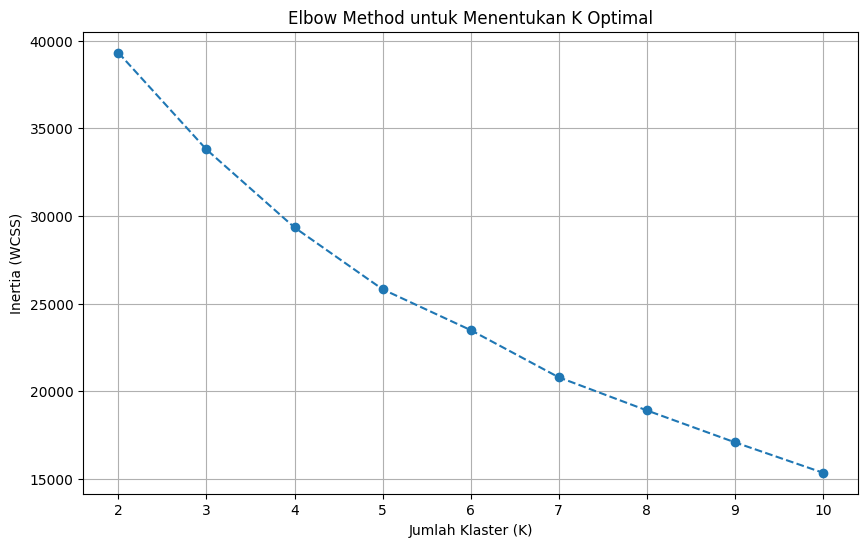

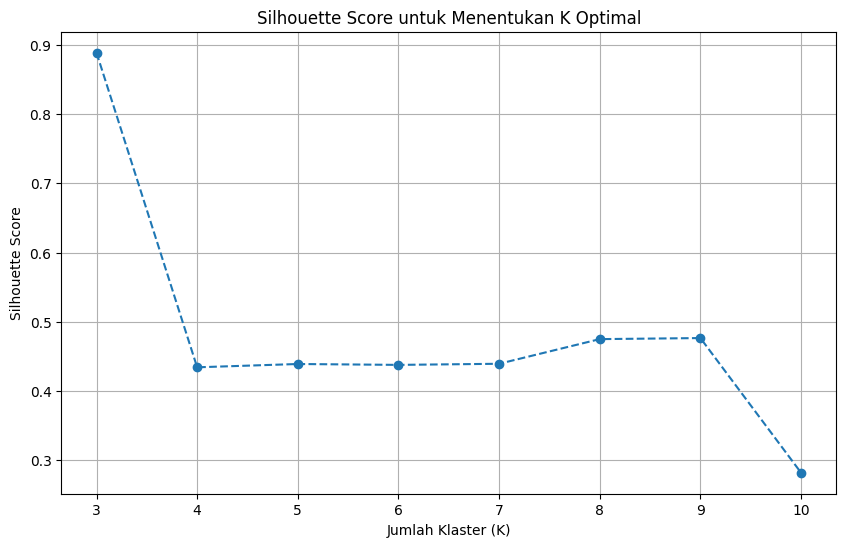

Berdasarkan Silhouette Score, K optimal yang disarankan adalah: 3
Melatih model K-Means final dengan K=3...
Kolom 'cluster_label' (K=3) telah ditambahkan ke tabel_bencana_cuaca.

Menjalankan Isolation Forest...
Kolom 'anomaly_score' telah ditambahkan ke tabel_bencana_cuaca.

Top 10 Kejadian Paling Anomali (Veracity Check Candidates) dari tabel_bencana_cuaca:


,id,Nama Kejadian,Kabupaten,TotalHujan_3Hari,Mengungsi,Rumah Terendam,anomaly_score
112,86d4e9f9-ca25-4e6f-8a52-5b8344201490,Tanah Longsor,Sukabumi,126.40,259,0,-0.326859
2506,be731dfb-7d2d-4d50-a429-f64a9c425f94,Banjir dan Tanah Longsor,Bogor,106.68,22504,0,-0.322396
2152,a6a0f338-45d6-4639-a6a3-6e6e49dddf01,Banjir dan Tanah Longsor,Garut,2.40,1360,2180,-0.303226
113,73c60a42-e3ff-43ea-955a-bd366d0adc97,Banjir,Sukabumi,126.40,209,253,-0.277426
185,47330db7-bff3-4841-ae8f-d6900d4d09f2,Banjir,Sukabumi,95.80,1491,1169,-0.259561
289,dc6218bb-1aa4-4d79-b8e3-d0ff52a4371f,Banjir,Bandung Barat,18.30,2352,45,-0.242095
189,8a14cce6-1f01-45b3-8951-cd49c57b52f4,Tanah Longsor,Cianjur,67.50,4172,0,-0.240243
764,b06f1a5a-e423-4d95-beed-10f0f1c44ff9,Banjir,Garut,41.25,1239,3510,-0.233190
2183,52f361f5-2b37-489e-bd59-76389b17c7fe,Banjir Bandang,Sukabumi,36.40,210,327,-0.232835
126,402f514a-4372-4134-943e-af52ff6d8f56,Banjir,Bogor,60.60,346,7384,-0.213346


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

if 'tabel_bencana_cuaca' not in locals():
    print("Peringatan: 'tabel_bencana_cuaca' tidak ditemukan. Harap jalankan blok sebelumnya.")
else:
    print("Memulai Analisis Clustering dan Deteksi Anomali pada tabel_bencana_cuaca...")

    kolom_dampak = [
        'Meninggal', 'Hilang', 'Luka / Sakit', 'Menderita', 'Mengungsi',
        'Rumah Rusak Berat', 'Rumah Rusak Sedang', 'Rumah Rusak Ringan', 'Rumah Terendam',
        'Satuan Pendidikan Rusak', 'Rumah Ibadat Rusak', 'Fasilitas Pelayanan Kesehatan Rusak',
        'Kantor Rusak', 'Jembatan Rusak'
    ]
    kolom_cuaca = [
        'RR', 'CurahHujan_H-1', 'CurahHujan_H-2', 'TotalHujan_3Hari', 'TotalHujan_7Hari'
    ]

    # Ensure only columns present in tabel_bencana_cuaca are selected
    features_cols = [col for col in kolom_dampak + kolom_cuaca if col in tabel_bencana_cuaca.columns]

    tabel_analisis_bencana_cuaca = tabel_bencana_cuaca.dropna(subset=features_cols)
    data_to_scale = tabel_analisis_bencana_cuaca[features_cols]

    print(f"Menggunakan {len(data_to_scale)} baris dan {len(features_cols)} fitur untuk analisis.")

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_to_scale)
    print("Data telah di-scale menggunakan StandardScaler.")

    print("\nMenjalankan K-Means Elbow Method...")
    inertia_values = []
    silhouette_scores = []
    possible_k = range(2, 11)

    for k in possible_k:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data_scaled)
        inertia_values.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(data_scaled, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(np.nan)

    plt.figure(figsize=(10, 6))
    plt.plot(possible_k, inertia_values, marker='o', linestyle='--')
    plt.title('Elbow Method untuk Menentukan K Optimal')
    plt.xlabel('Jumlah Klaster (K)')
    plt.ylabel('Inertia (WCSS)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(possible_k[1:], silhouette_scores[1:], marker='o', linestyle='--')
    plt.title('Silhouette Score untuk Menentukan K Optimal')
    plt.xlabel('Jumlah Klaster (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    if silhouette_scores[1:]:
        optimal_k_index = np.nanargmax(silhouette_scores[1:])
        K_OPTIMAL = possible_k[1:][optimal_k_index]
        print(f"Berdasarkan Silhouette Score, K optimal yang disarankan adalah: {K_OPTIMAL}")
    else:
        K_OPTIMAL = 4
        print(f"Tidak dapat menentukan K optimal dari Silhouette Score. Menggunakan K={K_OPTIMAL} sebagai default.")

    print(f"Melatih model K-Means final dengan K={K_OPTIMAL}...")

    kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
    kmeans_final.fit(data_scaled)

    # Assign cluster labels back to the original tabel_bencana_cuaca DataFrame
    tabel_bencana_cuaca.loc[tabel_analisis_bencana_cuaca.index, 'cluster_label'] = kmeans_final.labels_
    print(f"Kolom 'cluster_label' (K={K_OPTIMAL}) telah ditambahkan ke tabel_bencana_cuaca.")

    print("\nMenjalankan Isolation Forest...")
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    iso_forest.fit(data_scaled)

    scores = iso_forest.decision_function(data_scaled)

    # Assign anomaly scores back to the original tabel_bencana_cuaca DataFrame
    tabel_bencana_cuaca.loc[tabel_analisis_bencana_cuaca.index, 'anomaly_score'] = scores
    print("Kolom 'anomaly_score' telah ditambahkan ke tabel_bencana_cuaca.")

    print("\nTop 10 Kejadian Paling Anomali (Veracity Check Candidates) dari tabel_bencana_cuaca:")
    display(
        tabel_bencana_cuaca.sort_values(by='anomaly_score').head(10)[
            ['id', 'Nama Kejadian', 'Kabupaten', 'TotalHujan_3Hari', 'Mengungsi', 'Rumah Terendam', 'anomaly_score']
        ]
    )


### Analisis Hasil Clustering



Analisis Profil Klaster:

Profil Klaster (Rata-rata Fitur per Klaster):



,Meninggal,Hilang,Luka / Sakit,Menderita,Mengungsi,Rumah Rusak Berat,Rumah Rusak Sedang,Rumah Rusak Ringan,Rumah Terendam,Satuan Pendidikan Rusak,Rumah Ibadat Rusak,Fasilitas Pelayanan Kesehatan Rusak,Kantor Rusak,Jembatan Rusak,RR,CurahHujan_H-1,CurahHujan_H-2,TotalHujan_3Hari,TotalHujan_7Hari
cluster_label,,,,,,,,,,,,,,,,,,,
0,0.074360,0.006908,4.342950,919.143844,25.225518,1.039821,1.374644,2.023568,196.403495,0.048761,0.054043,0.005282,0.002844,0.043885,16.127348,13.966581,13.464709,43.558638,95.085474
1,4.250000,0.750000,2.750000,16150.500000,7073.750000,466.750000,558.500000,1255.750000,545.000000,14.500000,17.500000,2.500000,1.250000,17.500000,27.500000,9.290000,38.955000,75.745000,164.370833
2,1.076923,0.000000,20.615385,82020.153846,9070.230769,1.923077,1.538462,63.153846,23362.461538,15.923077,30.153846,0.384615,1.846154,0.000000,24.915385,6.715385,8.000000,39.630769,63.053846



Interpretasi Profil Klaster:

Dari tabel di atas, kita dapat mengamati karakteristik rata-rata dari setiap klaster. Ini membantu kita memahami jenis kejadian bencana yang cenderung dikelompokkan bersama oleh algoritma K-Means.

- **Klaster 0 - Kejadian Dampak Rendah/Umum (Ukuran: 2461 Kejadian)**: 
  Dicirikan oleh rata-rata:

    Meninggal: 0 orang
    Luka / Sakit: 4 orang
    Mengungsi: 25 orang
    Rumah Rusak Berat: 1 unit
    Rumah Terendam: 196 unit
    RR: 16.13 mm
    TotalHujan_3Hari: 43.56 mm


- **Klaster 1 - Kejadian Dampak Tinggi: Pengungsian & Kerusakan Rumah Berat (Ukuran: 4 Kejadian)**: 
  Dicirikan oleh rata-rata:

    Meninggal: 4 orang
    Luka / Sakit: 3 orang
    Mengungsi: 7074 orang
    Rumah Rusak Berat: 467 unit
    Rumah Terendam: 545 unit
    RR: 27.50 mm
    TotalHujan_3Hari: 75.75 mm


- **Klaster 2 - Kejadian Dampak Sangat Tinggi: Banjir Ekstensif & Pengungsian Massal (Ukuran: 13 Kejadian)**: 
  Dicirikan oleh rata-rata:

    Meninggal: 1 orang
    Luka 

,count
cluster_label,
0,2461
1,4
2,13



Visualisasi Klaster



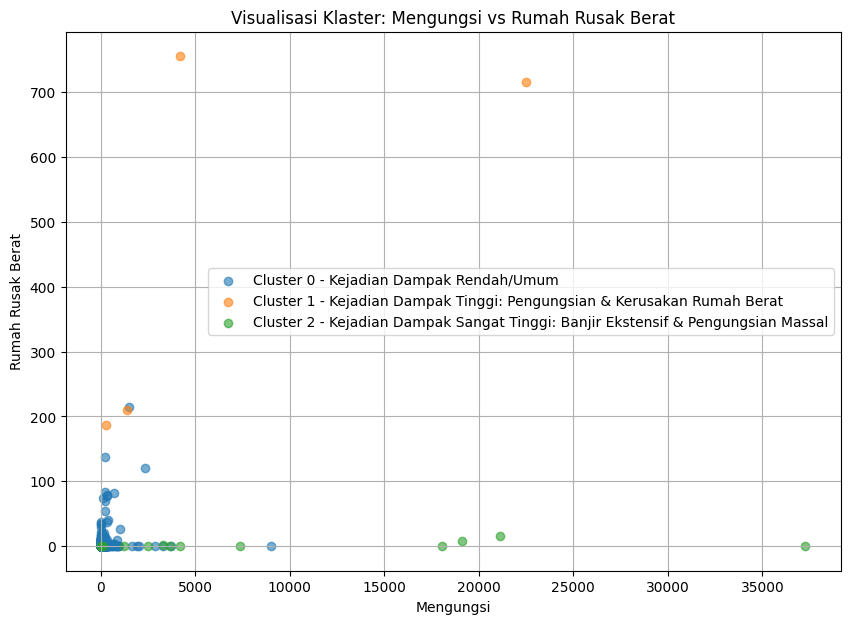

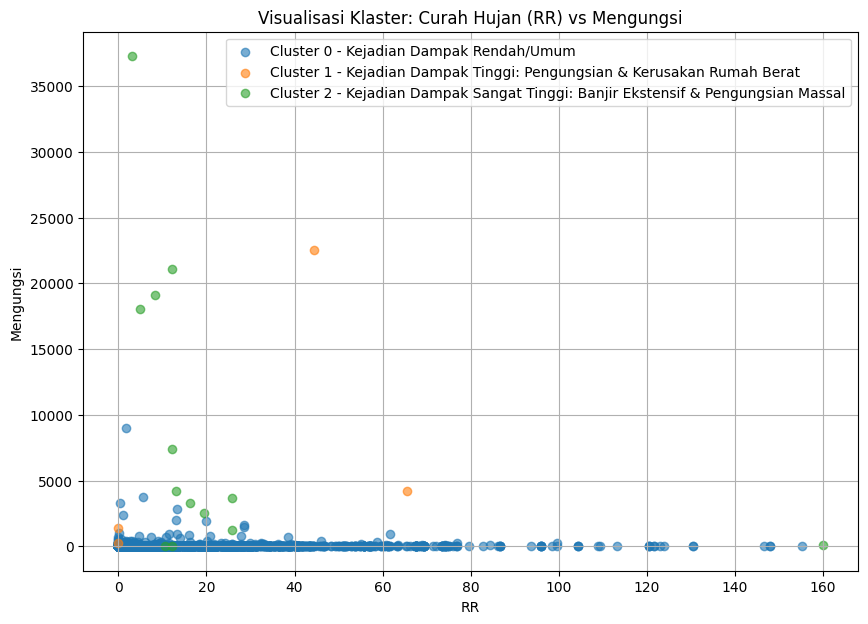

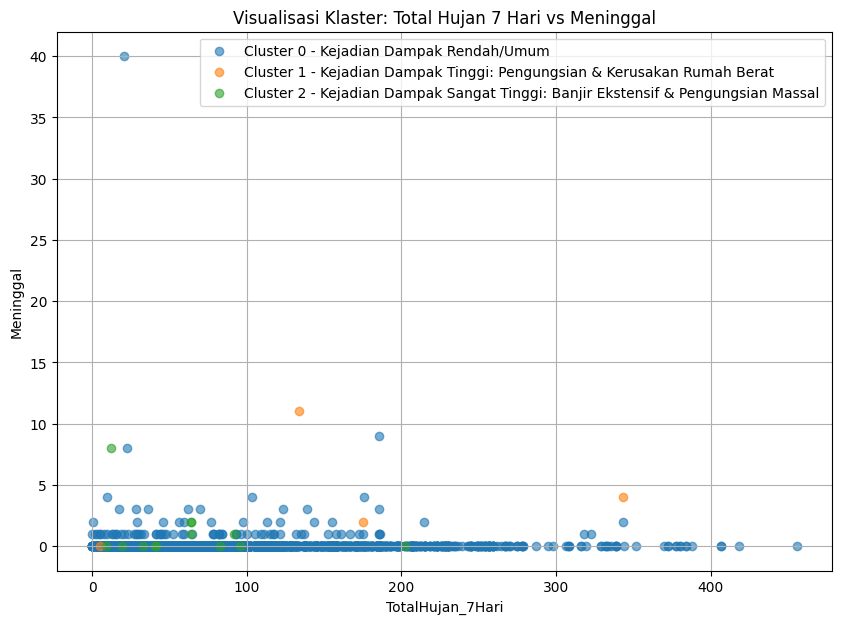

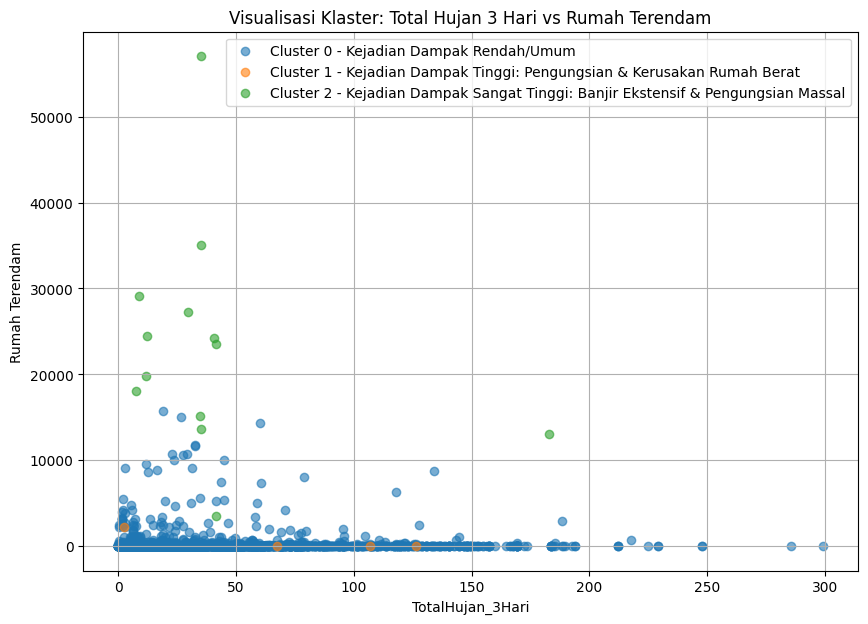

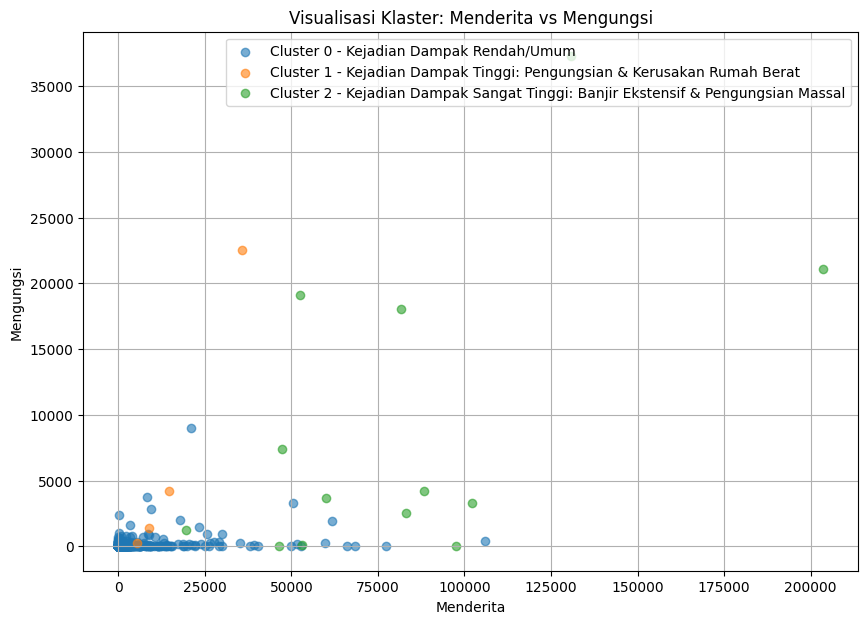

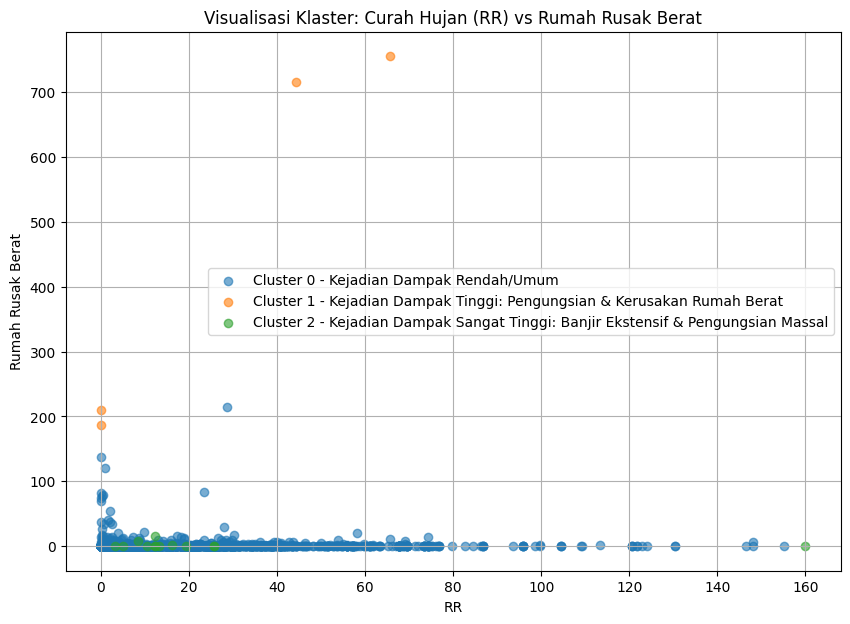

Analisis klaster selesai.


In [ ]:
print("\nAnalisis Profil Klaster:\n")

kolom_dampak_valid_clustering = [col for col in [
    'Meninggal', 'Hilang', 'Luka / Sakit', 'Menderita', 'Mengungsi',
    'Rumah Rusak Berat', 'Rumah Rusak Sedang', 'Rumah Rusak Ringan', 'Rumah Terendam',
    'Satuan Pendidikan Rusak', 'Rumah Ibadat Rusak', 'Fasilitas Pelayanan Kesehatan Rusak',
    'Kantor Rusak', 'Jembatan Rusak'
] if col in tabel_bencana_cuaca.columns]

kolom_cuaca_clustering = [
    'RR', 'CurahHujan_H-1', 'CurahHujan_H-2', 'TotalHujan_3Hari', 'TotalHujan_7Hari'
]

features_for_profile = [col for col in kolom_dampak_valid_clustering + kolom_cuaca_clustering if col in tabel_bencana_cuaca.columns]

df_clustered = tabel_bencana_cuaca.dropna(subset=['cluster_label']).copy()

if not features_for_profile:
    print("Peringatan: Tidak ada kolom numerik yang relevan untuk analisis profil klaster.")
elif df_clustered.empty:
    print("Peringatan: 'df_clustered' kosong setelah dropna. Tidak dapat membuat profil klaster.")
else:
    df_clustered['cluster_label'] = df_clustered['cluster_label'].astype(int)

    profil_cluster = df_clustered.groupby('cluster_label')[features_for_profile].mean()

    print("Profil Klaster (Rata-rata Fitur per Klaster):\n")
    display(profil_cluster)

    print("\nInterpretasi Profil Klaster:\n")
    print("Dari tabel di atas, kita dapat mengamati karakteristik rata-rata dari setiap klaster. Ini membantu kita memahami jenis kejadian bencana yang cenderung dikelompokkan bersama oleh algoritma K-Means.\n")

    distribusi_klaster = df_clustered['cluster_label'].value_counts().sort_index()

    # Refined cluster names based on observation of profil_cluster
    cluster_names = {
        0: "Kejadian Dampak Rendah/Umum",
        1: "Kejadian Dampak Tinggi: Pengungsian & Kerusakan Rumah Berat",
        2: "Kejadian Dampak Sangat Tinggi: Banjir Ekstensif & Pengungsian Massal"
    }

    if 'K_OPTIMAL' not in locals():
        K_OPTIMAL = df_clustered['cluster_label'].nunique()

    for cluster_id in sorted(profil_cluster.index):
        name = cluster_names.get(cluster_id, f"Klaster {cluster_id}")
        print(f"- **Klaster {cluster_id} - {name} (Ukuran: {distribusi_klaster[cluster_id]} Kejadian)**: ")
        print(f"  Dicirikan oleh rata-rata:\n")
        for feature in ['Meninggal', 'Luka / Sakit', 'Mengungsi', 'Rumah Rusak Berat', 'Rumah Terendam', 'RR', 'TotalHujan_3Hari']:
            if feature in profil_cluster.columns:
                if feature == 'Meninggal' or feature == 'Luka / Sakit' or feature == 'Mengungsi' or feature == 'Menderita' or feature == 'Hilang':
                    print(f"    {feature}: {profil_cluster.loc[cluster_id, feature]:.0f} orang")
                elif feature == 'Rumah Rusak Berat' or feature == 'Rumah Rusak Sedang' or feature == 'Rumah Rusak Ringan' or feature == 'Rumah Terendam' or feature == 'Satuan Pendidikan Rusak' or feature == 'Rumah Ibadat Rusak' or feature == 'Fasilitas Pelayanan Kesehatan Rusak' or feature == 'Kantor Rusak' or feature == 'Jembatan Rusak':
                    print(f"    {feature}: {profil_cluster.loc[cluster_id, feature]:.0f} unit")
                else:
                    print(f"    {feature}: {profil_cluster.loc[cluster_id, feature]:.2f} mm")
        print("\n")

    print("\n(Interpretasi di atas didasarkan pada angka aktual dari `profil_cluster`.)")

    print("\nDistribusi Kejadian per Klaster:\n")
    display(distribusi_klaster)

    print("\nVisualisasi Klaster\n")

    # Define feature combinations for plotting, including the original and new ones
    plot_combinations_all = [
        ('Mengungsi', 'Rumah Rusak Berat', 'Mengungsi vs Rumah Rusak Berat'),
        ('RR', 'Mengungsi', 'Curah Hujan (RR) vs Mengungsi'),
        ('TotalHujan_7Hari', 'Meninggal', 'Total Hujan 7 Hari vs Meninggal'),
        ('TotalHujan_3Hari', 'Rumah Terendam', 'Total Hujan 3 Hari vs Rumah Terendam'),
        ('Menderita', 'Mengungsi', 'Menderita vs Mengungsi'),
        ('RR', 'Rumah Rusak Berat', 'Curah Hujan (RR) vs Rumah Rusak Berat')
    ]

    for feature_x, feature_y, plot_title_suffix in plot_combinations_all:
        if feature_x in df_clustered.columns and feature_y in df_clustered.columns:
            plt.figure(figsize=(10, 7))
            for i in range(K_OPTIMAL):
                subset = df_clustered[df_clustered['cluster_label'] == i]
                plt.scatter(subset[feature_x], subset[feature_y], label=f'Cluster {i} - {cluster_names.get(i, 'Unknown')}', alpha=0.6)

            plt.xlabel(feature_x)
            plt.ylabel(feature_y)
            plt.title(f'Visualisasi Klaster: {plot_title_suffix}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Peringatan: Kolom '{feature_x}' atau '{feature_y}' tidak ditemukan. Melewatkan plot: {plot_title_suffix}")

    print("Analisis klaster selesai.")

In [ ]:
from sklearn.metrics import silhouette_score


if 'data_scaled' in locals() and 'kmeans_final' in locals():
    kolom_dampak = [
        'Meninggal', 'Hilang', 'Luka / Sakit', 'Menderita', 'Mengungsi',
        'Rumah Rusak Berat', 'Rumah Rusak Sedang', 'Rumah Rusak Ringan', 'Rumah Terendam',
        'Satuan Pendidikan Rusak', 'Rumah Ibadat Rusak', 'Fasilitas Pelayanan Kesehatan Rusak',
        'Kantor Rusak', 'Jembatan Rusak'
    ]
    kolom_cuaca = [
        'RR', 'CurahHujan_H-1', 'CurahHujan_H-2', 'TotalHujan_3Hari', 'TotalHujan_7Hari'
    ]
    features_cols = [col for col in kolom_dampak + kolom_cuaca if col in tabel_bencana_cuaca.columns]

    data_for_clustering_numeric = tabel_bencana_cuaca.dropna(subset=features_cols)[features_cols]
    scaler = StandardScaler()
    data_scaled_for_clustering = scaler.fit_transform(data_for_clustering_numeric)


    if len(data_scaled_for_clustering) == len(kmeans_final.labels_):
        silhouette_avg = silhouette_score(data_scaled_for_clustering, kmeans_final.labels_)
        print(f"\nSilhouette Score untuk model K-Means dengan K={K_OPTIMAL}: {silhouette_avg:.4f}")
    else:
        print("Peringatan: Jumlah sampel 'data_scaled_for_clustering' dan 'kmeans_final.labels_' masih tidak konsisten. Mohon periksa kembali alur eksekusi.")
else:
    print("Peringatan: Variabel 'data_scaled' atau 'kmeans_final' tidak ditemukan. Harap pastikan blok clustering telah dijalankan.")


Silhouette Score untuk model K-Means dengan K=3: 0.8887


#**Analisis Spasial-Temporal menggunakan LSTM Seq2Seq**

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

if 'tabel_analitik_master' not in locals():
    print("Peringatan: 'tabel_analitik_master' tidak ada. Harap jalankan blok sebelumnya.")
else:
    print(f"TensorFlow Versi: {tf.__version__}")
    print("Library siap digunakan.")

TensorFlow Versi: 2.19.0
Library siap digunakan.


In [ ]:
print("Memulai persiapan data runtun waktu harian...")

tabel_analitik_master['tanggal'] = pd.to_datetime(tabel_analitik_master['tanggal'], errors='coerce')
start_date = tabel_analitik_master['tanggal'].min()
end_date = tabel_analitik_master['tanggal'].max()

if pd.isnull(start_date) or pd.isnull(end_date):
    start_date = '2020-01-01'
    end_date = '2025-09-30'
    print(f"Menggunakan rentang tanggal manual: {start_date} hingga {end_date}")

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_harian = pd.DataFrame(date_range, columns=['Tanggal'])

df_hulu = tabel_analitik_master[
    tabel_analitik_master['Nama_Stasiun'] == 'Stasiun Geofisika Bandung'
].copy()
df_hulu['Tanggal'] = pd.to_datetime(df_hulu['Tanggal_Kejadian_Key'])
df_hulu_harian = df_hulu.drop_duplicates(subset=['Tanggal'])
df_hulu_harian = df_hulu_harian.set_index('Tanggal')['TotalHujan_3Hari']

df_hilir = tabel_analitik_master[
    tabel_analitik_master['Kabupaten'] == 'Karawang'
].copy()
df_hilir['Tanggal'] = pd.to_datetime(df_hilir['Tanggal_Kejadian_Key'])
df_hilir_harian = df_hilir.groupby('Tanggal')['Rumah Terendam'].sum()

df_harian = df_harian.merge(df_hulu_harian, on='Tanggal', how='left', suffixes=('', '_hulu'))
df_harian = df_harian.merge(df_hilir_harian, on='Tanggal', how='left', suffixes=('', '_hilir'))

df_harian['TotalHujan_3Hari'] = df_harian['TotalHujan_3Hari'].fillna(0)
df_harian['Rumah Terendam'] = df_harian['Rumah Terendam'].fillna(0)

print("Data runtun waktu harian (Hulu & Hilir) berhasil dibuat:")
display(df_harian.describe())
display(df_harian.tail())

Memulai persiapan data runtun waktu harian...
Data runtun waktu harian (Hulu & Hilir) berhasil dibuat:


,Tanggal,TotalHujan_3Hari,Rumah Terendam
count,2100,2100.000000,2100.000000
mean,2022-11-15 12:00:00.000000256,8.525877,80.831905
min,2020-01-01 00:00:00,0.000000,0.000000
25%,2021-06-08 18:00:00,0.000000,0.000000
50%,2022-11-15 12:00:00,0.000000,0.000000
75%,2024-04-23 06:00:00,2.900000,0.000000
max,2025-09-30 00:00:00,182.900000,29092.000000
std,NaN,20.630942,1052.503111


,Tanggal,TotalHujan_3Hari,Rumah Terendam
2095,2025-09-26,0.0,0.0
2096,2025-09-27,0.0,0.0
2097,2025-09-28,0.0,0.0
2098,2025-09-29,0.0,0.0
2099,2025-09-30,0.0,0.0


In [ ]:
print("Melakukan penskalaan data (MinMaxScaler)...")
scaler_hujan = MinMaxScaler(feature_range=(0, 1))
scaler_dampak = MinMaxScaler(feature_range=(0, 1))

data_hujan_scaled = scaler_hujan.fit_transform(df_harian[['TotalHujan_3Hari']])
data_dampak_scaled = scaler_dampak.fit_transform(df_harian[['Rumah Terendam']])

data_scaled = np.hstack((data_hujan_scaled, data_dampak_scaled))

def create_sliding_window(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x = data[i:end_ix, 0]
        seq_y = data[end_ix:out_end_ix, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

N_STEPS_IN = 7
N_STEPS_OUT = 3

X, y = create_sliding_window(data_scaled, N_STEPS_IN, N_STEPS_OUT)

print(f"Bentuk data X (Input) sebelum di-reshape: {X.shape}")
print(f"Bentuk data y (Output) sebelum di-reshape: {y.shape}")

N_FEATURES = 1
X = X.reshape((X.shape[0], X.shape[1], N_FEATURES))
y = y.reshape((y.shape[0], y.shape[1], N_FEATURES))

print(f"Bentuk data X (Input) FINAL: {X.shape}")
print(f"Bentuk data y (Output) FINAL: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data latih: {X_train.shape[0]} sampel, Data tes: {X_test.shape[0]} sampel")

Melakukan penskalaan data (MinMaxScaler)...
Bentuk data X (Input) sebelum di-reshape: (2091, 7)
Bentuk data y (Output) sebelum di-reshape: (2091, 3)
Bentuk data X (Input) FINAL: (2091, 7, 1)
Bentuk data y (Output) FINAL: (2091, 3, 1)
Data latih: 1672 sampel, Data tes: 419 sampel


In [ ]:
print("Membangun model LSTM Seq2Seq...")

model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(N_STEPS_IN, N_FEATURES)))

model.add(RepeatVector(N_STEPS_OUT))

model.add(LSTM(100, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')

model.summary()

Membangun model LSTM Seq2Seq...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 1)           │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Memulai pelatihan model...
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0018 - val_loss: 5.0182e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 5.1804e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 5.0475e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 5.0410e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 5.1688e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 5.1313e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 5.0427e-04
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0016 - val_loss: 5.0211e-04
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 5.0270e-04
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 5.0246e-04
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 5.0

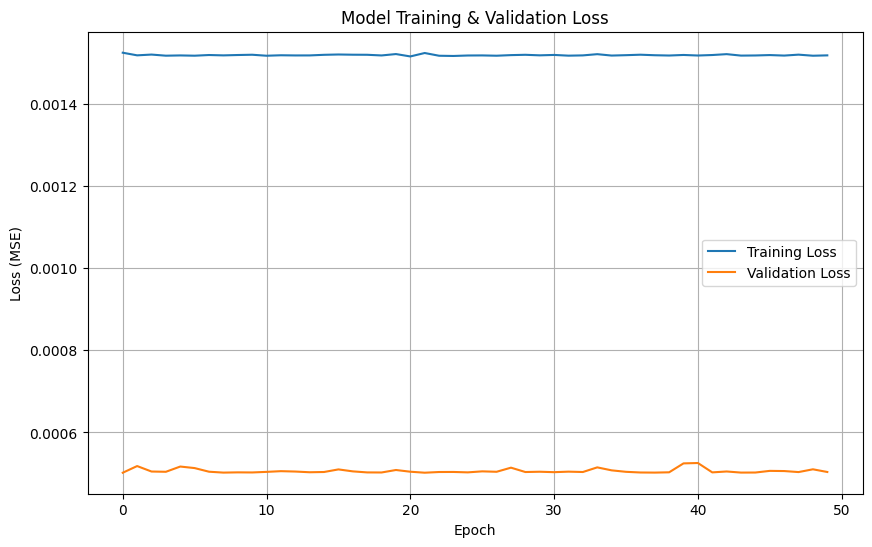

In [ ]:
print("Memulai pelatihan model...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    batch_size=32
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Melakukan prediksi pada data tes...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Memplot hasil prediksi vs aktual untuk validasi time-lag...


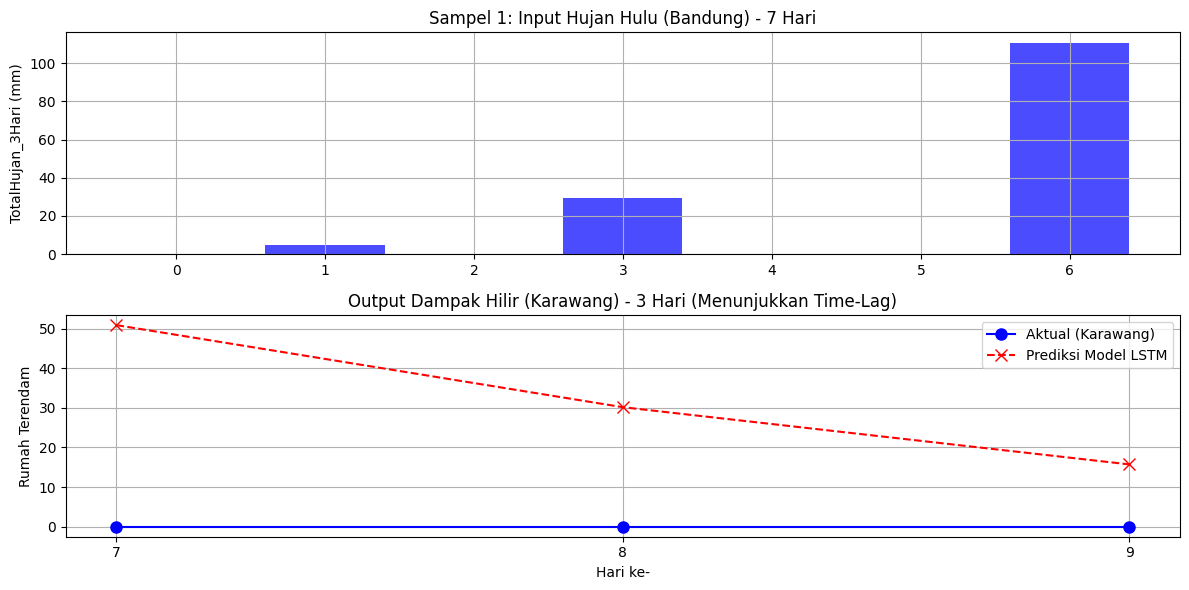

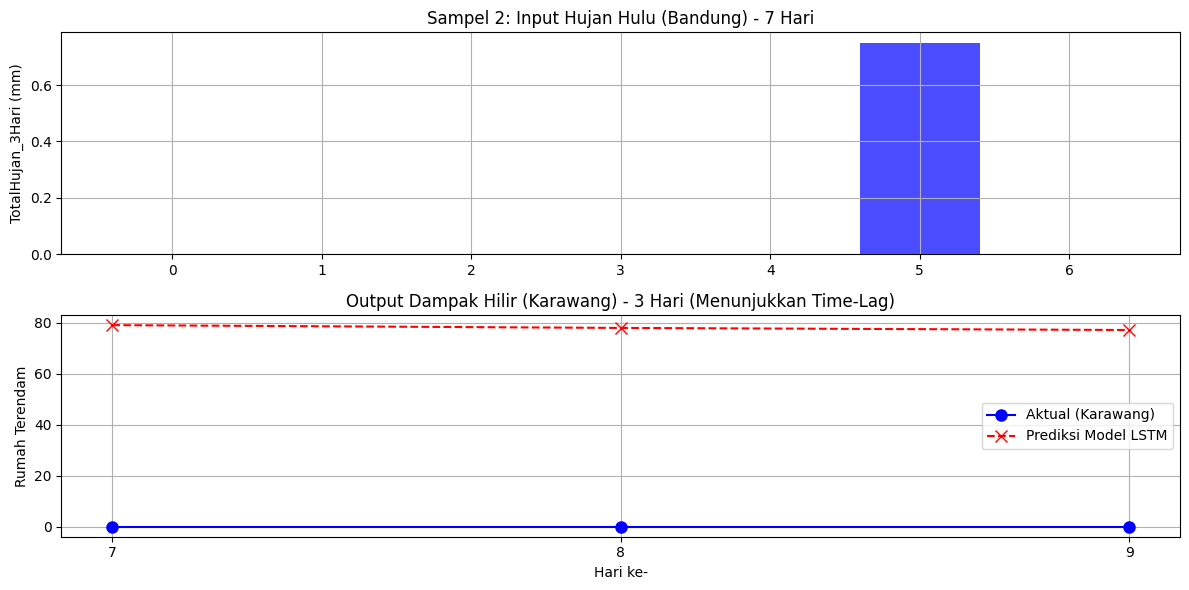

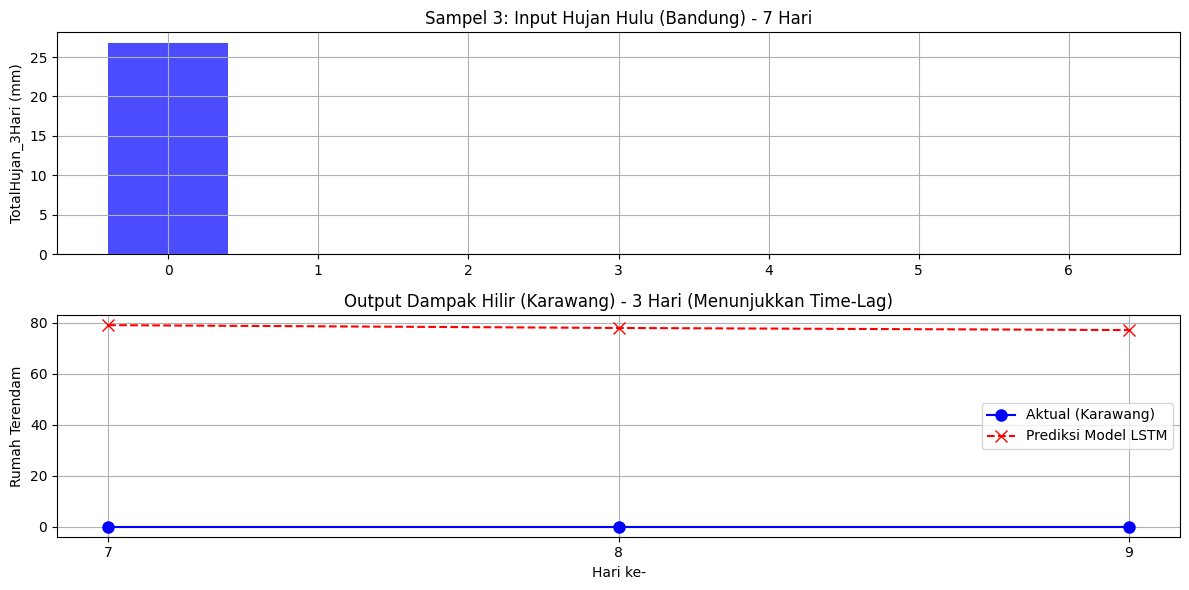

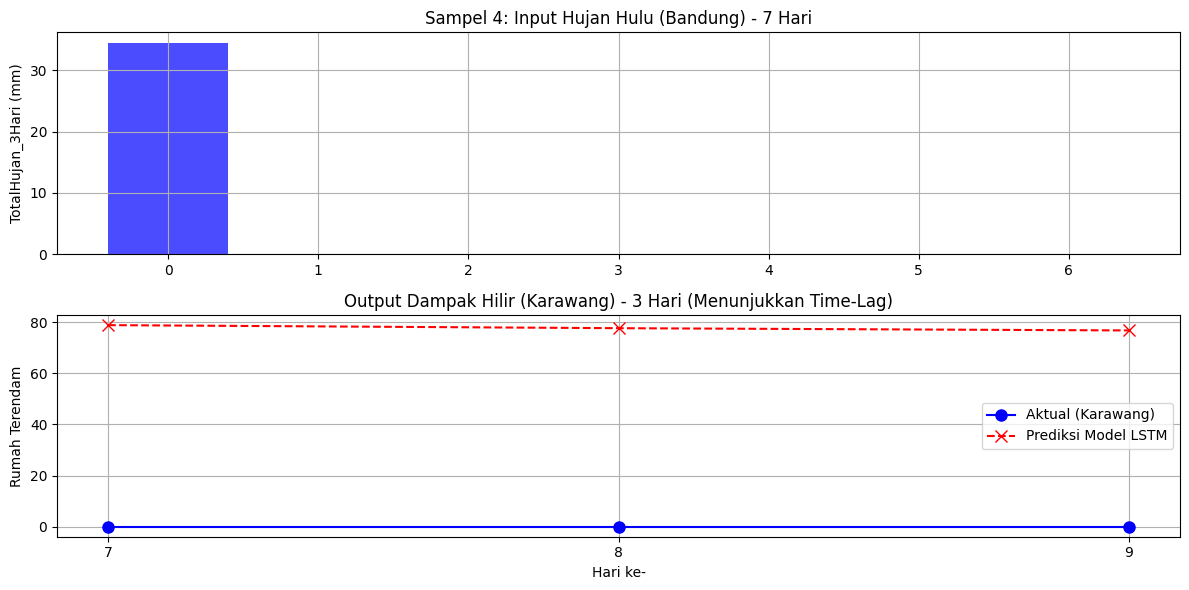

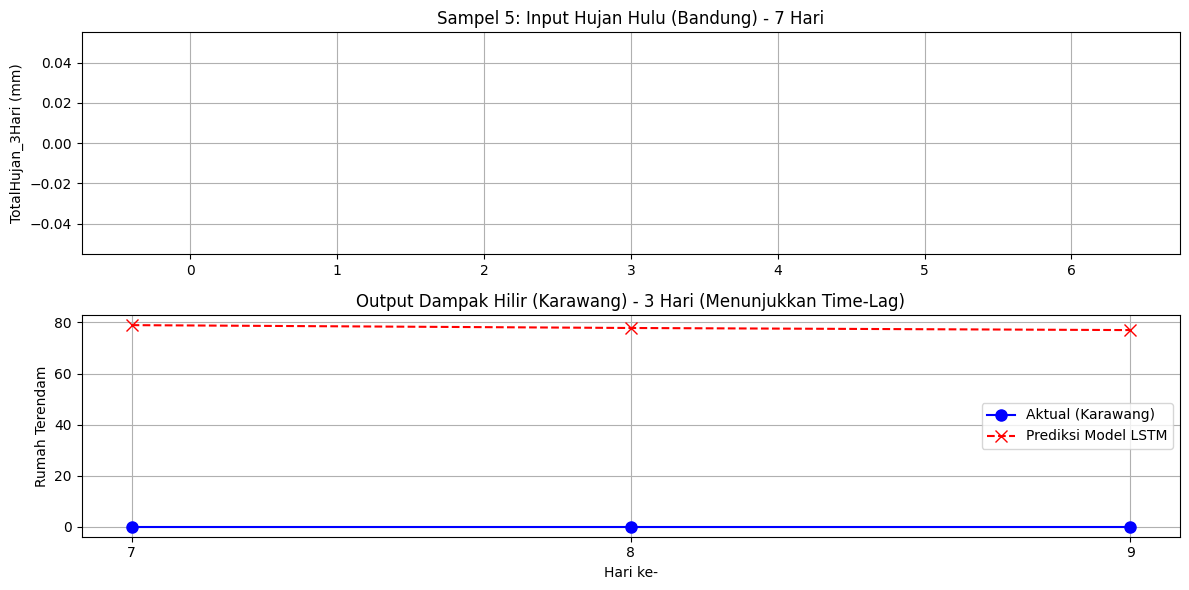

Analisis Selesai. Perhatikan plot di atas.
Jika plot 'Prediksi' (merah) berhasil mengikuti pola 'Aktual' (biru),
maka model telah berhasil mempelajari time-lag antara hujan di hulu dan banjir di hilir.


In [ ]:
print("Melakukan prediksi pada data tes...")
y_pred_scaled = model.predict(X_test)

y_test_actual = scaler_dampak.inverse_transform(
    y_test.reshape(-1, N_FEATURES)
).reshape(y_test.shape)

y_pred_actual = scaler_dampak.inverse_transform(
    y_pred_scaled.reshape(-1, N_FEATURES)
).reshape(y_pred_scaled.shape)


print("Memplot hasil prediksi vs aktual untuk validasi time-lag...")

n_plots = 5
plot_indices = np.random.choice(len(X_test), n_plots, replace=False)

for i, idx in enumerate(plot_indices):
    plt.figure(figsize=(12, 6))

    x_input_actual = scaler_hujan.inverse_transform(X_test[idx])
    plt.subplot(2, 1, 1)
    plt.bar(range(N_STEPS_IN), x_input_actual.flatten(), color='blue', alpha=0.7)
    plt.title(f'Sampel {i+1}: Input Hujan Hulu (Bandung) - 7 Hari')
    plt.ylabel('TotalHujan_3Hari (mm)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    pred_days = range(N_STEPS_IN, N_STEPS_IN + N_STEPS_OUT)

    plt.plot(pred_days, y_test_actual[idx].flatten(), 'bo-', label='Aktual (Karawang)', markersize=8)
    plt.plot(pred_days, y_pred_actual[idx].flatten(), 'rx--', label='Prediksi Model LSTM', markersize=8)
    plt.title('Output Dampak Hilir (Karawang) - 3 Hari (Menunjukkan Time-Lag)')
    plt.ylabel('Rumah Terendam')
    plt.xlabel('Hari ke-')
    plt.xticks(pred_days)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Analisis Selesai. Perhatikan plot di atas.")
print("Jika plot 'Prediksi' (merah) berhasil mengikuti pola 'Aktual' (biru),")
print("maka model telah berhasil mempelajari time-lag antara hujan di hulu dan banjir di hilir.")

## Persiapan Data untuk Model Alternatif


In [ ]:
print("Memulai persiapan fitur tambahan untuk model alternatif...")

df_alt_model = df_harian.copy()
df_alt_model = df_alt_model.set_index('Tanggal')

print("DataFrame `df_alt_model` dibuat dengan 'Tanggal' sebagai indeks.")
display(df_alt_model.head())

Memulai persiapan fitur tambahan untuk model alternatif...
DataFrame `df_alt_model` dibuat dengan 'Tanggal' sebagai indeks.


,TotalHujan_3Hari,Rumah Terendam
Tanggal,,
2020-01-01,13.4,0.0
2020-01-02,15.6,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0


In [ ]:
print("Membuat fitur lag untuk 'TotalHujan_3Hari' dan 'Rumah Terendam'...")
for i in range(1, 8): # Lag 1 hingga 7 hari
    df_alt_model[f'Hujan_Hulu_Lag_{i}'] = df_alt_model['TotalHujan_3Hari'].shift(i)
    df_alt_model[f'Dampak_Hilir_Lag_{i}'] = df_alt_model['Rumah Terendam'].shift(i)

print("Membuat fitur rolling window untuk 'TotalHujan_3Hari' dan 'Rumah Terendam'...")
df_alt_model['Hujan_Hulu_RollMean_3D'] = df_alt_model['TotalHujan_3Hari'].rolling(window=3).mean()
df_alt_model['Hujan_Hulu_RollMean_7D'] = df_alt_model['TotalHujan_3Hari'].rolling(window=7).mean()
df_alt_model['Dampak_Hilir_RollMean_3D'] = df_alt_model['Rumah Terendam'].rolling(window=3).mean()
df_alt_model['Dampak_Hilir_RollMean_7D'] = df_alt_model['Rumah Terendam'].rolling(window=7).mean()

print("Mengekstrak fitur berbasis waktu (bulan, hari dalam seminggu, tahun)...")
df_alt_model['Bulan'] = df_alt_model.index.month
df_alt_model['Hari_Dalam_Minggu'] = df_alt_model.index.dayofweek
df_alt_model['Tahun'] = df_alt_model.index.year

print("Menangani missing values (mengisi dengan 0 atau drop baris)...")
# Missing values dari lag dan rolling features biasanya diisi 0 atau di-drop
df_alt_model = df_alt_model.fillna(0) # Mengisi NaN dengan 0

print("Data dengan fitur tambahan selesai disiapkan.")
print("Lima baris pertama DataFrame yang telah diperkaya fitur:")
display(df_alt_model.head())
print("Informasi DataFrame (info()):")
df_alt_model.info()

Membuat fitur lag untuk 'TotalHujan_3Hari' dan 'Rumah Terendam'...
Membuat fitur rolling window untuk 'TotalHujan_3Hari' dan 'Rumah Terendam'...
Mengekstrak fitur berbasis waktu (bulan, hari dalam seminggu, tahun)...
Menangani missing values (mengisi dengan 0 atau drop baris)...
Data dengan fitur tambahan selesai disiapkan.
Lima baris pertama DataFrame yang telah diperkaya fitur:


,TotalHujan_3Hari,Rumah Terendam,Hujan_Hulu_Lag_1,Dampak_Hilir_Lag_1,Hujan_Hulu_Lag_2,Dampak_Hilir_Lag_2,Hujan_Hulu_Lag_3,Dampak_Hilir_Lag_3,Hujan_Hulu_Lag_4,Dampak_Hilir_Lag_4,...,Dampak_Hilir_Lag_6,Hujan_Hulu_Lag_7,Dampak_Hilir_Lag_7,Hujan_Hulu_RollMean_3D,Hujan_Hulu_RollMean_7D,Dampak_Hilir_RollMean_3D,Dampak_Hilir_RollMean_7D,Bulan,Hari_Dalam_Minggu,Tahun
Tanggal,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,2,2020
2020-01-02,15.6,0.0,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,3,2020
2020-01-03,0.0,0.0,15.6,0.0,13.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.666667,0.0,0.0,0.0,1,4,2020
2020-01-04,0.0,0.0,0.0,0.0,15.6,0.0,13.4,0.0,0.0,0.0,...,0.0,0.0,0.0,5.200000,0.0,0.0,0.0,1,5,2020
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,15.6,0.0,13.4,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,6,2020


Informasi DataFrame (info()):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2020-01-01 to 2025-09-30
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalHujan_3Hari          2100 non-null   float64
 1   Rumah Terendam            2100 non-null   float64
 2   Hujan_Hulu_Lag_1          2100 non-null   float64
 3   Dampak_Hilir_Lag_1        2100 non-null   float64
 4   Hujan_Hulu_Lag_2          2100 non-null   float64
 5   Dampak_Hilir_Lag_2        2100 non-null   float64
 6   Hujan_Hulu_Lag_3          2100 non-null   float64
 7   Dampak_Hilir_Lag_3        2100 non-null   float64
 8   Hujan_Hulu_Lag_4          2100 non-null   float64
 9   Dampak_Hilir_Lag_4        2100 non-null   float64
 10  Hujan_Hulu_Lag_5          2100 non-null   float64
 11  Dampak_Hilir_Lag_5        2100 non-null   float64
 12  Hujan_Hulu_Lag_6          2100 non-null   float64
 13  Dampak_Hilir_La

## Eksplorasi Model Machine Learning (XGBoost/LightGBM)



In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Pastikan 'tabel_analitik_master' Anda sudah ada
if 'tabel_analitik_master' not in locals():
    print("Peringatan: 'tabel_analitik_master' tidak ada. Harap jalankan blok sebelumnya.")
else:
    print(f"XGBoost Versi: {xgb.__version__}")
    print("Library siap digunakan.")

XGBoost Versi: 3.1.1
Library siap digunakan.


In [ ]:
print("Memulai persiapan data runtun waktu harian...")

# Tentukan rentang tanggal penuh sesuai data Anda
tabel_analitik_master['tanggal'] = pd.to_datetime(tabel_analitik_master['tanggal'], errors='coerce')
start_date = tabel_analitik_master['tanggal'].min()
end_date = tabel_analitik_master['tanggal'].max()

if pd.isnull(start_date) or pd.isnull(end_date):
    start_date = '2020-01-01'
    end_date = '2025-09-30'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_harian = pd.DataFrame(date_range, columns=['Tanggal'])

# --- 1. Siapkan Data HULU (Input X) ---
df_hulu = tabel_analitik_master[
    tabel_analitik_master['Nama_Stasiun'] == 'Stasiun Geofisika Bandung'
].copy()
df_hulu['Tanggal'] = pd.to_datetime(df_hulu['Tanggal_Kejadian_Key'])
df_hulu_harian = df_hulu.drop_duplicates(subset=['Tanggal']).set_index('Tanggal')['TotalHujan_3Hari']

# --- 2. Siapkan Data HILIR (Output Y) ---
df_hilir = tabel_analitik_master[
    tabel_analitik_master['Kabupaten'] == 'Karawang'
].copy()
df_hilir['Tanggal'] = pd.to_datetime(df_hilir['Tanggal_Kejadian_Key'])
df_hilir_harian = df_hilir.groupby('Tanggal')['Rumah Terendam'].sum()

# --- 3. Gabungkan ke DataFrame Harian ---
df_harian = df_harian.merge(df_hulu_harian, on='Tanggal', how='left')
df_harian = df_harian.merge(df_hilir_harian, on='Tanggal', how='left')
df_harian['TotalHujan_3Hari'] = df_harian['TotalHujan_3Hari'].fillna(0)
df_harian['Rumah Terendam'] = df_harian['Rumah Terendam'].fillna(0)

print("Data runtun waktu harian (Hulu & Hilir) berhasil dibuat:")
display(df_harian.head())

Memulai persiapan data runtun waktu harian...
Data runtun waktu harian (Hulu & Hilir) berhasil dibuat:


,Tanggal,TotalHujan_3Hari,Rumah Terendam
0,2020-01-01,13.4,0.0
1,2020-01-02,15.6,0.0
2,2020-01-03,0.0,0.0
3,2020-01-04,0.0,0.0
4,2020-01-05,0.0,0.0


In [ ]:
print("Membuat fitur lag tabular untuk XGBoost...")

# Tentukan parameter
N_DAYS_INPUT = 7  # 7 hari data hujan
N_DAYS_LAG = 2    # Target prediksi 2 hari ke depan (sesuai hipotesis )

df_xgb = df_harian.copy()
df_xgb = df_xgb.set_index('Tanggal') # Bekerja dengan indeks tanggal lebih mudah

# --- 1. Buat Fitur (X) ---
# Buat kolom fitur lag untuk data hujan hulu
feature_cols = []
for i in range(N_DAYS_INPUT):
    col_name = f'Hujan_Hulu_t-{i}'
    df_xgb[col_name] = df_xgb['TotalHujan_3Hari'].shift(i)
    feature_cols.append(col_name)

# --- 2. Buat Target (Y) ---
# Geser data dampak hilir ke BELAKANG sebanyak N_DAYS_LAG
target_col = f'Dampak_Hilir_t+{N_DAYS_LAG}'
df_xgb[target_col] = df_xgb['Rumah Terendam'].shift(-N_DAYS_LAG)

# --- 3. Bersihkan Data ---
# Hapus baris dengan NaN yang dihasilkan oleh proses shifting
df_xgb = df_xgb.dropna()

print(f"Data tabular berhasil dibuat dengan {len(df_xgb)} sampel.")

# --- 4. Pisahkan X dan y ---
X = df_xgb[feature_cols]
y = df_xgb[target_col]

display(X.head())
display(y.head())

# --- 5. Split Data Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# 'shuffle=False' penting untuk data runtun waktu

print(f"Data latih: {len(X_train)} sampel, Data tes: {len(X_test)} sampel")

Membuat fitur lag tabular untuk XGBoost...
Data tabular berhasil dibuat dengan 2092 sampel.


,Hujan_Hulu_t-0,Hujan_Hulu_t-1,Hujan_Hulu_t-2,Hujan_Hulu_t-3,Hujan_Hulu_t-4,Hujan_Hulu_t-5,Hujan_Hulu_t-6
Tanggal,,,,,,,
2020-01-07,0.0,0.0,0.0,0.0,0.0,15.6,13.4
2020-01-08,3.3,0.0,0.0,0.0,0.0,0.0,15.6
2020-01-09,9.3,3.3,0.0,0.0,0.0,0.0,0.0
2020-01-10,16.3,9.3,3.3,0.0,0.0,0.0,0.0
2020-01-11,0.0,16.3,9.3,3.3,0.0,0.0,0.0


,Dampak_Hilir_t+2
Tanggal,
2020-01-07,45.0
2020-01-08,8839.0
2020-01-09,0.0
2020-01-10,0.0
2020-01-11,0.0


Data latih: 1673 sampel, Data tes: 419 sampel


In [ ]:
print("Membangun dan melatih model XGBoost...")

# Buat model XGBRegressor
# n_estimators = jumlah pohon
# learning_rate = seberapa cepat model belajar
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50, # Berhenti jika 50 putaran tidak ada kemajuan
    random_state=42
)

# Latih model
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], # Gunakan data tes untuk early stopping
    verbose=False # Set 'True' jika ingin lihat proses
)

print("Model XGBoost selesai dilatih.")

Membangun dan melatih model XGBoost...
Model XGBoost selesai dilatih.


Melakukan evaluasi model...
Hasil Evaluasi Model:
  Root Mean Squared Error (RMSE): 470.28
  R-squared (R2 Score): -0.0038

--- Insight: Validasi Jeda Waktu (Feature Importance) ---


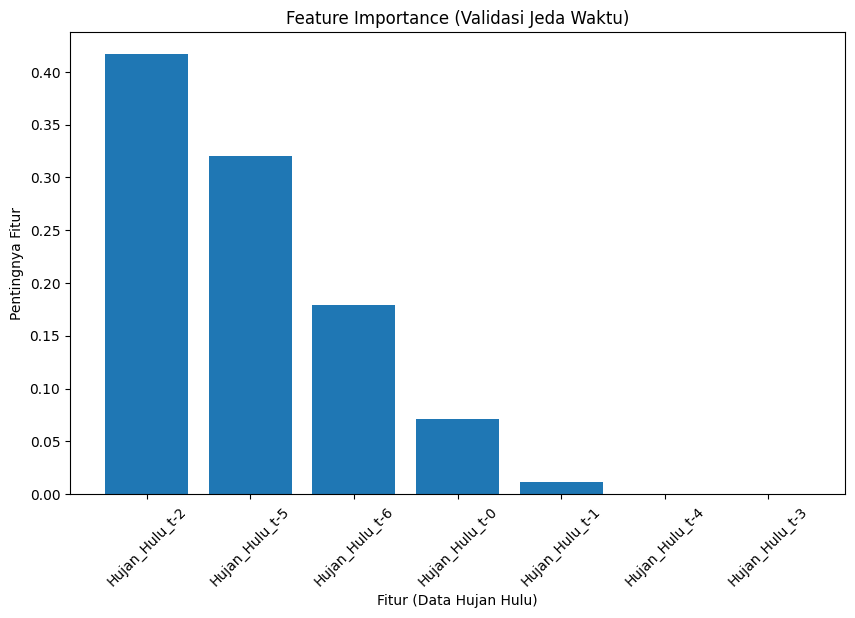

Interpretasi Plot:
Plot di atas menunjukkan hari lag mana yang dianggap paling penting oleh model.
Jika fitur seperti 'Hujan_Hulu_t-2' atau 'Hujan_Hulu_t-5' (misal: Hujan_Hulu_t-0, t-1, atau t-2) 
memiliki nilai tertinggi, ini MEMVALIDASI hipotesis time-lag Anda.

--- Insight: Performa Prediksi (Aktual vs Prediksi) ---


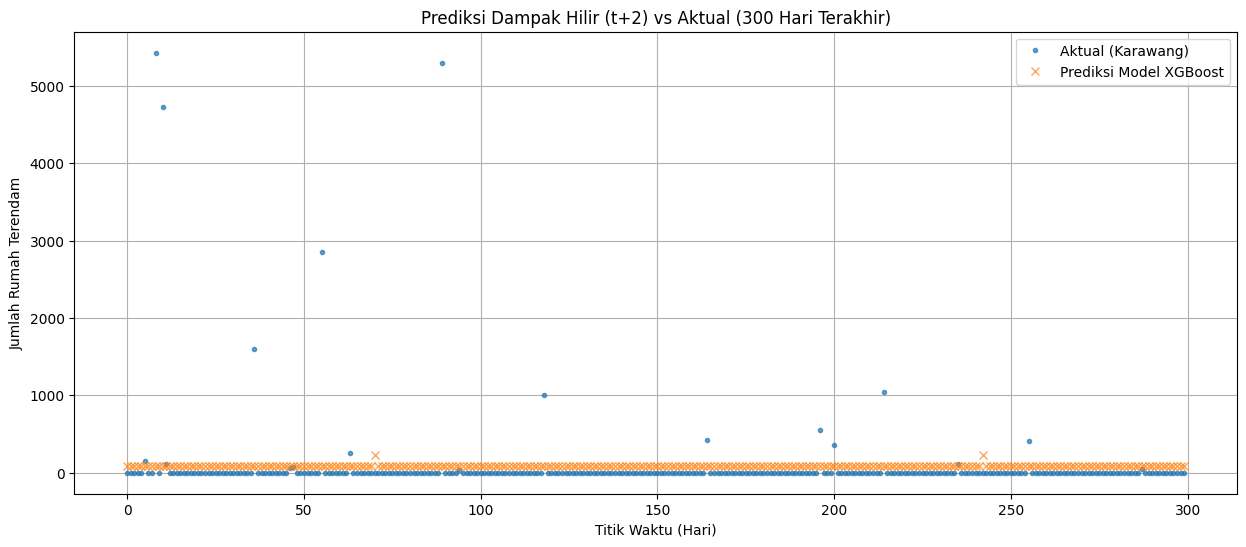

Analisis Spasial-Temporal (XGBoost) selesai.


In [ ]:
print("Melakukan evaluasi model...")

# Lakukan prediksi pada data tes
y_pred = model_xgb.predict(X_test)

# Hitung metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Hasil Evaluasi Model:")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  R-squared (R2 Score): {r2:.4f}")

# --- INSIGHT 1: Feature Importance (Validasi Time-Lag) ---
print("\n--- Insight: Validasi Jeda Waktu (Feature Importance) ---")

feature_importance = model_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=45)
plt.title('Feature Importance (Validasi Jeda Waktu)')
plt.ylabel('Pentingnya Fitur')
plt.xlabel('Fitur (Data Hujan Hulu)')
plt.show()

print("Interpretasi Plot:")
print("Plot di atas menunjukkan hari lag mana yang dianggap paling penting oleh model.")
print(f"Jika fitur seperti '{feature_names[sorted_idx[0]]}' atau '{feature_names[sorted_idx[1]]}' (misal: Hujan_Hulu_t-0, t-1, atau t-2) \nmemiliki nilai tertinggi, ini MEMVALIDASI hipotesis time-lag Anda.")


# --- INSIGHT 2: Plot Prediksi vs Aktual ---
print("\n--- Insight: Performa Prediksi (Aktual vs Prediksi) ---")

plt.figure(figsize=(15, 6))
# Ambil 300 titik data terakhir untuk visualisasi
plt.plot(y_test.values[-300:], label='Aktual (Karawang)', marker='.', linestyle='None', alpha=0.7)
plt.plot(y_pred[-300:], label='Prediksi Model XGBoost', marker='x', linestyle='None', alpha=0.7)
plt.title('Prediksi Dampak Hilir (t+2) vs Aktual (300 Hari Terakhir)')
plt.ylabel('Jumlah Rumah Terendam')
plt.xlabel('Titik Waktu (Hari)')
plt.legend()
plt.grid(True)
plt.show()

print("Analisis Spasial-Temporal (XGBoost) selesai.")